# Imports

NumPy will be used for almost everything, but also import a few other libraries to read the data and make visualizations.

#### CIFAR-10 Dataset
Images of size 32x32 and 3 channels because they are color images.

Each row of the CVS has 3073 columns: 1 column for the label + 3072 columns for pixel values (32x32).

It has 10 classes:
- 0 = airplane
- 1 = automobile
- 2 = bird
- 3 = cat
- 4 = deer
- 5 = dog
- 6 = frog
- 7 = horse
- 8 = ship
- 9 = truck


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import wandb

# Load CSVs
train_df = pd.read_csv("train_CIFAR.csv")
test_df  = pd.read_csv("test_CIFAR.csv")

# Check data 
print("Train rows:", len(train_df))
print("Train cols:", len(train_df.columns))
print("Test rows:", len(test_df))
print("Test cols:", len(test_df.columns))

# Extract labels and features
y_train = train_df.iloc[:, -1].to_numpy()
X_train = train_df.iloc[:, :-1].to_numpy()
X_test  = test_df.to_numpy()

# Normalize pixel values to [0, 1]
X_train = X_train.astype(np.float32) / 255.0
X_test  = X_test.astype(np.float32) / 255.0

print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape)


Train rows: 50000
Train cols: 3073
Test rows: 10000
Test cols: 3072
Training set: (50000, 3072) (50000,)
Test set: (10000, 3072)


Unique labels: [0 1 2 3 4 5 6 7 8 9]
Number of samples per label:
Class 0 (airplane): 5000 samples
Class 1 (automobile): 5000 samples
Class 2 (bird): 5000 samples
Class 3 (cat): 5000 samples
Class 4 (deer): 5000 samples
Class 5 (dog): 5000 samples
Class 6 (frog): 5000 samples
Class 7 (horse): 5000 samples
Class 8 (ship): 5000 samples
Class 9 (truck): 5000 samples


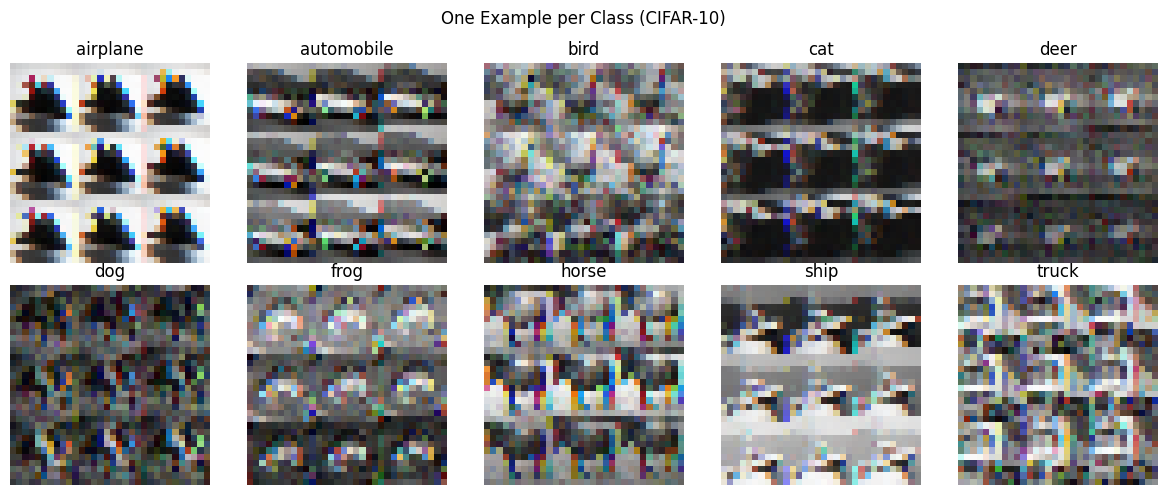

Pixel intensity statistics:
  min=0.000, max=1.000
  mean=0.473, std=0.252


In [2]:
# CIFAR-10 label names
cifar10_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# dataset info
print("Unique labels:", np.unique(y_train))
print("Number of samples per label:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u} ({cifar10_labels[u]}): {c} samples")

# Plot one sample per label
plt.figure(figsize=(12, 5))
for label in range(10):
    idx = np.where(y_train == label)[0][0]
    img = X_train[idx].reshape(32, 32, 3)
    
    plt.subplot(2, 5, label + 1)
    plt.imshow(img)
    plt.title(f"{cifar10_labels[label]}")
    plt.axis("off")

plt.suptitle("One Example per Class (CIFAR-10)")
plt.tight_layout()
plt.show()

# Compute pixel-level statistics
print("Pixel intensity statistics:")
print(f"  min={X_train.min():.3f}, max={X_train.max():.3f}")
print(f"  mean={X_train.mean():.3f}, std={X_train.std():.3f}")


In [3]:

# Prepare Train / Validation Split
split_ratio = 0.9
n_total = len(X_train)
split_idx = int(n_total * split_ratio)

#  make it random
perm = np.random.permutation(n_total)
X_train, y_train = X_train[perm], y_train[perm]

# Split
X_val = X_train[split_idx:]
y_val = y_train[split_idx:]
X_train = X_train[:split_idx]
y_train = y_train[:split_idx]

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")


Train set: (45000, 3072), (45000,)
Validation set: (5000, 3072), (5000,)


# One-Hot Encoding for Labels
The output layer of the network consists of 10 neurons, each representing one of the ten possible numbers. To ensure consistency in dimensionality across labels in the dataset and facilitate calculations of loss and other metrics, I will one-hot encode the labels. This will generate an array of length 10 for each label, where all elements are set to 0 except for the index corresponding to the label. 

In [4]:
y_train_samples = y_train[:10]
y_val_samples = y_val[:10]

num_classes = len(np.unique(y_train))
y_train = np.eye(num_classes)[y_train]
y_val = np.eye(num_classes)[y_val]


y_train_onehot_samples = y_train[:10]
for y, y_onehot in zip(y_train_samples, y_train_onehot_samples):
    label_name = cifar10_labels[int(y)]
    print(f"Original label: {y,label_name} | One-hot encoded label: {y_onehot}")
print('--------------------------------------------------------------')
y_val_onehot_samples = y_val[:10]
for y, y_onehot_val in zip(y_val_samples, y_val_onehot_samples):
    label_name = cifar10_labels[int(y)]
    print(f"Original label: {y,label_name} | One-hot encoded label: {y_onehot_val}")

Original label: (2, 'bird') | One-hot encoded label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Original label: (9, 'truck') | One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Original label: (2, 'bird') | One-hot encoded label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Original label: (7, 'horse') | One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Original label: (0, 'airplane') | One-hot encoded label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original label: (2, 'bird') | One-hot encoded label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Original label: (7, 'horse') | One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Original label: (4, 'deer') | One-hot encoded label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Original label: (3, 'cat') | One-hot encoded label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Original label: (7, 'horse') | One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
--------------------------------------------------------------
Original label: (9, 'truck') | One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 0

# Creating a Dataloader
I've implemented a generator functions that returns a batch of data. It is a highly simplified version of dataloader classes.

Batch X shape: (64, 3072) Batch y shape: (64, 10)
Labels in this batch: [0. 1.]


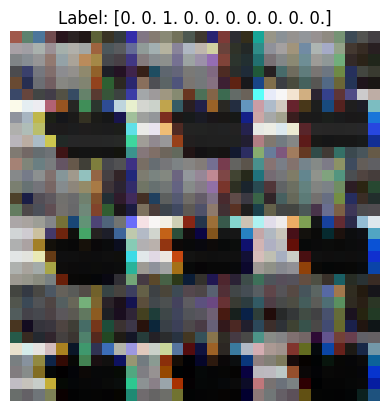

In [5]:
def get_batch(X, y, batch_size):
    n_batches = X.shape[0] // batch_size
    for i in range(n_batches):
        X_batch = X[i*batch_size:(i+1)*batch_size]
        y_batch = y[i*batch_size:(i+1)*batch_size]
        yield X_batch, y_batch

# Try function
batch_size = 64
for Xb, yb in get_batch(X_train, y_train, batch_size):
    print("Batch X shape:", Xb.shape, "Batch y shape:", yb.shape)
    print("Labels in this batch:", np.unique(yb))
    # Show the first image of this batch
    plt.imshow(Xb[0].reshape(32, 32, 3))
    plt.title(f"Label: {yb[0]}")
    plt.axis('off')
    plt.show()
    break  # remove this to loop through all batches




Add random shufling per epoch, as we will need that to train a network with randomized batches each epoch, so digits are not seen in order.

Batch: (128, 3072) (128, 10)
Labels in this batch: [0. 1.]


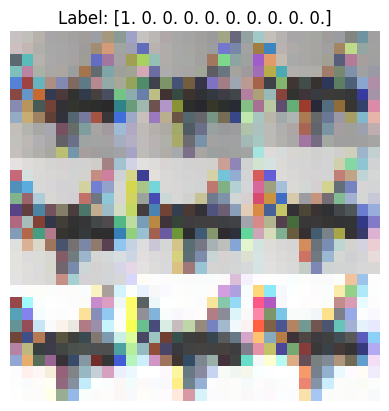

In [6]:
def get_batch(X, y, batch_size, shuffle=True):
    idx = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(idx)
    for i in range(0, X.shape[0] - batch_size + 1, batch_size):
        batch_idx = idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

# Test function -> when run multiple times, output changes (above never changes)
batch_size = 128
for Xb, yb in get_batch(X_train, y_train, batch_size, shuffle=True): # set shuffle to True
    print("Batch:", Xb.shape, yb.shape)
    print("Labels in this batch:", np.unique(yb))
    # Show the first image of this batch
    plt.imshow(Xb[0].reshape(32, 32, 3))
    plt.title(f"Label: {yb[0]}")
    plt.axis('off')
    plt.show()
    break  # remove this to loop through all batches




# Activation Functions
Activation functions are mathematical functions applied to the output of each neuron in a neural network's hidden layers. They introduce non-linearity to the network, enabling it to learn complex patterns in data. Without activation functions, neural networks would essentially reduce to linear transformations, which limits their ability to learn complex relationships in data.

I've used two different activations functions in my network architecture, Rectified Linear Unit (ReLU) and SoftMax. The former is used in the hidden layer, and the latter is applied to the output layer. 

ReLU sets all negative values to zero and leaves positive values unchanged. For a given input x, is defined as
$$
ReLU(x) = max(0,x)
$$

SoftMax is commonly used in the output layer of a neural network. It converts the raw output scores into probabilities, ensuring that the sum of the probabilities across all classes equals one. It is defined as
$$
p_i = \frac{e^{z_i}}{\sum e^{z_j}}
$$

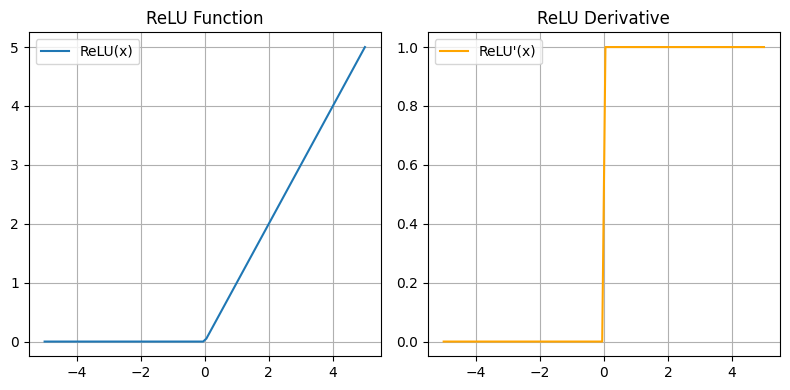

Softmax output:
 [[0.63806635 0.23473149 0.0954347  0.03176745]
 [0.11035682 0.81543273 0.04958652 0.02462393]
 [0.10189196 0.08342208 0.75288537 0.06180059]]
Row sums (should be 1): [1. 1. 1.]


In [7]:
# ReLU
def relu(x):
    return np.maximum(x, 0)

# ReLU derivative for backpropagation
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# SoftMax
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Test ReLUs
x = np.linspace(-5, 5, 100) # Input range

# Apply ReLU and its derivative
y = relu(x)
dy = relu_derivative(x)

# Plot
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(x, y, label='ReLU(x)')
plt.title("ReLU Function")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(x, dy, color='orange', label="ReLU'(x)")
plt.title("ReLU Derivative")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Test SoftMax
logits = np.array([
    [2.0, 1.0, 0.1, -1.0],
    [1.0, 3.0, 0.2, -0.5],
    [0.5, 0.3, 2.5, 0.0]
]) # Input logits for 3 samples × 4 classes

probs = softmax(logits)
print("Softmax output:\n", probs)
print("Row sums (should be 1):", np.sum(probs, axis=1))

# Forward Pass

This image explains the mathematical operations involved in forward and backward pass.

![Forward_Backward_Pass.png](attachment:Forward_Backward_Pass.png)

##### Input and Hidden Layer

Starting from the bottom, we have the input values, so the flattened input images denoted as $x=a^0$. 
\
We also have the weights that connect the input layer to the first and only hidden layer $w^1$, as well as the bias of the hidden layer $b^1$. Then, we calculate the first weighted sum $z^1$ as
$$
a^0 = x
$$
$$
z^1 = w^1*a^0 + b^1
$$ 
The weighted sum is passed through an activation function
$$
a^1 = f(z^1) = ReLU(z^1)
$$

##### Hidden and Output Layer

The output from the activation function of the hidden layer is used as input for the next layer and it repeats as many times as layers in the network.
$$
z^2 = w^2a^1+b^2
$$
$$
a^2 = SoftMax(z^2)
$$
The output layer is special, as the SoftMax function is applied. Therefore, the output of this activation function $a^2$ is the prediction of the network, usually denoted as $\hat{y}$.


In [8]:
# For 2 layers network
def forward(X, W1, b1, W2, b2):
    z1 = X @ W1 + b1
    a1 = relu(z1)
    z2 = a1 @ W2 + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2

# Test forward pass
X_sample = np.random.rand(5, 784)  # 5 samples, 784 features

# Layer sizes
input_size = 784
hidden_size = 128
output_size = 10

# initial weights & biases
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))

# Forward pass
z1, a1, z2, a2 = forward(X_sample, W1, b1, W2, b2)

print("z1 shape:", z1.shape)
print("a1 shape:", a1.shape)
print("z2 shape:", z2.shape)
print("a2 shape:", a2.shape)
print("Row sums of a2 (should be 1):", np.sum(a2, axis=1))


z1 shape: (5, 128)
a1 shape: (5, 128)
z2 shape: (5, 10)
a2 shape: (5, 10)
Row sums of a2 (should be 1): [1. 1. 1. 1. 1.]


But now, we want to make it flexible, so the user can choose the number of hidden layers, as well as the number of hiden units per layer by setting that up in a list.

Then, weights and biases will be stored in lists to loop them dynamically.

In [9]:
# Loop over the sizes of the network that are send in a list
def init_network(layer_sizes):
    """
    layer_sizes: list of layer sizes that form network including input and output.
    Example: [784, 128, 64, 10] = input -> 128 -> 64 -> output
    With this list, the user is defining both: 
    - number of hidden layers (lenght of list)
    - number of hidden units (numbers in list)
    """
    params = []
    for i in range(len(layer_sizes) - 1):
        W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2. / layer_sizes[i])
        b = np.zeros((1, layer_sizes[i+1]))
        params.append((W, b))
    return params

# Forward pass
def forward_flexible(X, params):
    """
    params: list of (W, b) tuples for each layer
    Returns: (activations, pre_activations)
    """
    activations = [X]
    pre_activations = []
    
    for i, (W, b) in enumerate(params):
        z = activations[-1] @ W + b
        pre_activations.append(z)
        
        # Apply ReLU for hidden layers, Softmax for last
        if i < len(params) - 1:
            a = relu(z)
        else:
            a = softmax(z)
        activations.append(a)
        
    return pre_activations, activations


# Test it
# Architecture: input → 128 → 64 → output(10)
layer_sizes = [784, 128, 82, 64, 10]
params = init_network(layer_sizes)

# Forward pass
X_sample = np.random.rand(5, 784)
pre_acts, acts = forward_flexible(X_sample, params)

for i, (z, a) in enumerate(zip(pre_acts, acts[1:])):
    print(f"Layer {i+1}: z.shape={z.shape}, a.shape={a.shape}")


Layer 1: z.shape=(5, 128), a.shape=(5, 128)
Layer 2: z.shape=(5, 82), a.shape=(5, 82)
Layer 3: z.shape=(5, 64), a.shape=(5, 64)
Layer 4: z.shape=(5, 10), a.shape=(5, 10)


# Optimizers
Implement SGD, Adam and Momentum Optimizers.

In [10]:
def init_optimizer_states(params, optimizer='sgd'):
    """Initialize optimizer-specific states."""
    if optimizer == 'momentum':
        v = [ (np.zeros_like(W), np.zeros_like(b)) for W, b in params ]
        return {'v': v}
    elif optimizer == 'adam':
        m = [ (np.zeros_like(W), np.zeros_like(b)) for W, b in params ]
        v = [ (np.zeros_like(W), np.zeros_like(b)) for W, b in params ]
        return {'m': m, 'v': v, 't': 0}
    else:
        return {}  # SGD has no state

# Update Parameters
To update the parameters, i.e. the weights and biases, we first need to define a learning rate $\alpha$. 
\
The learning rate is a hyperparameter that determines the step size at which the model's parameters are updated during the training process. We'll use the optimization algorithms gradient descent to minimize the loss function. The learning rate controls the size of the steps taken in the direction opposite to the gradient of the loss function. Defined as
$$
\theta_{new} = \theta_{old} - \alpha*C
$$

In [11]:
# For 2 layers network

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2


# Flexible network
def update_parameters_flexible(params, grads, learning_rate, optimizer='sgd', opt_state=None, beta1=0.9, beta2=0.999, eps=1e-8, momentum=0.9):
    """Update parameters according to selected optimizer."""
    new_params = []

    if optimizer == 'sgd':
        for (W, b), (dW, db) in zip(params, grads):
            W -= learning_rate * dW
            b -= learning_rate * db
            new_params.append((W, b))

    elif optimizer == 'momentum':
        for i, ((W, b), (dW, db)) in enumerate(zip(params, grads)):
            vW, vb = opt_state['v'][i]
            vW = momentum * vW - learning_rate * dW
            vb = momentum * vb - learning_rate * db
            W += vW
            b += vb
            new_params.append((W, b))
            opt_state['v'][i] = (vW, vb)

    elif optimizer == 'adam':
        opt_state['t'] += 1
        t = opt_state['t']

        for i, ((W, b), (dW, db)) in enumerate(zip(params, grads)):
            mW, mb = opt_state['m'][i]
            vW, vb = opt_state['v'][i]

            # Update biased first moment estimate
            mW = beta1 * mW + (1 - beta1) * dW
            mb = beta1 * mb + (1 - beta1) * db
            # Update biased second raw moment estimate
            vW = beta2 * vW + (1 - beta2) * (dW ** 2)
            vb = beta2 * vb + (1 - beta2) * (db ** 2)
            # Bias correction
            mW_hat = mW / (1 - beta1 ** t)
            mb_hat = mb / (1 - beta1 ** t)
            vW_hat = vW / (1 - beta2 ** t)
            vb_hat = vb / (1 - beta2 ** t)
            # Update parameters
            W -= learning_rate * mW_hat / (np.sqrt(vW_hat) + eps)
            b -= learning_rate * mb_hat / (np.sqrt(vb_hat) + eps)

            opt_state['m'][i] = (mW, mb)
            opt_state['v'][i] = (vW, vb)
            new_params.append((W, b))

    return new_params, opt_state


# Weight Initialization
While it's possible to start training with random weights and biases, it is generally a good idea to use a better method to set the initial parameter values as it leads to faster convergence.

Different types can be implemented: \
    - He Initialization: better for ReLU activations
    $$
    std = \sqrt{2/n_{in}}
    $$
    - Xavier Initialization: better for tanh/sigmoid activations
    $$
    std = \sqrt{1/n_{in}}
    $$

In [12]:
# for a flexible network and lets chose between the 2 methods
def init_weights_flexible(layer_sizes, method='he'):
    """
    layer_sizes: list of layer sizes, e.g. [784, 128, 64, 10]
    method: 'he' or 'xavier'
    
    Returns:
        params: list of (W, b) pairs
    """
    params = []
    for i in range(len(layer_sizes) - 1):
        in_dim = layer_sizes[i]
        out_dim = layer_sizes[i + 1]

        if method.lower() == 'he':
            scale = np.sqrt(2. / in_dim)
        elif method.lower() == 'xavier':
            scale = np.sqrt(1. / in_dim)
        else:
            raise ValueError("Unknown initialization method. Use 'he' or 'xavier'.")

        W = np.random.randn(in_dim, out_dim) * scale
        b = np.zeros((1, out_dim))
        params.append((W, b))

    return params

# Test it
# He initialization
params_he = init_weights_flexible([784, 128, 64, 10], method='he')

# Xavier initialization
params_xavier = init_weights_flexible([784, 128, 64, 10], method='xavier')

# Check layer shapes
for i, (W, b) in enumerate(params_he):
    print(f"Layer {i+1}: W shape {W.shape}, b shape {b.shape}")

print('------------------------------------')

# Check layer shapes
for i, (W, b) in enumerate(params_xavier):
    print(f"Layer {i+1}: W shape {W.shape}, b shape {b.shape}")



Layer 1: W shape (784, 128), b shape (1, 128)
Layer 2: W shape (128, 64), b shape (1, 64)
Layer 3: W shape (64, 10), b shape (1, 10)
------------------------------------
Layer 1: W shape (784, 128), b shape (1, 128)
Layer 2: W shape (128, 64), b shape (1, 64)
Layer 3: W shape (64, 10), b shape (1, 10)


# Loss functions

In the previous section, we calculated the output $a^2 = \hat{y}$. This value alongside the ground truth label $y$ is run through a loss function. 
\
Ideally, at each iteration the value of the loss function should decrease, indicating the model's improving ability to learn. There are multiple options to use.

\
The Mean Squared Error function (MSE) is defined as
$$
Loss = \frac{1}{2}(a_k-y_k)^2
$$

The Cross Entropy Loss defines as
$$
Loss = -\sum y_k log(a_k)
$$

We will also get the gradients of the loss functions needed for backpropagation.

In [13]:
# Loss Functions 
def mean_squared_error(y_true, y_pred):
    """Mean Squared Error (for regression or optional classification)."""
    loss = np.mean(np.sum((y_true - y_pred) ** 2, axis=1) / 2.0)
    dA = (y_pred - y_true) / y_true.shape[0]
    return loss, dA

def cross_entropy_loss(y_true, y_pred, eps=1e-12):
    """Categorical Cross-Entropy (for one-hot labels)."""
    y_pred_clipped = np.clip(y_pred, eps, 1 - eps)
    loss = -np.mean(np.sum(y_true * np.log(y_pred_clipped), axis=1))
    dA = (y_pred - y_true) / y_true.shape[0]
    return loss, dA


# Test it
y_true = np.eye(10)[np.array([3, 1, 4, 0])]   # one-hot labels
y_pred = np.random.rand(4, 10)
y_pred = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=1, keepdims=True)  # softmax normalize


# Compute loss and gradient
loss, dA = cross_entropy_loss(y_true, y_pred)
print("Loss:", loss)
print("dA shape:", dA.shape)


Loss: 2.3777215373227323
dA shape: (4, 10)


# Dropout

Add dropout for some training loops.

In [14]:
# Dropout 
def apply_dropout(a, dropout_rate):
    if dropout_rate <= 0: return a, np.ones_like(a)
    mask = (np.random.rand(*a.shape) > dropout_rate).astype(np.float32)
    return a * mask / (1 - dropout_rate), mask

# Accuracy Function

In [15]:
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

# Test it
acc = accuracy(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.0


# Backward Pass

To calculate the changes that we need to make to the network parameters, we need to calculate the gradients of the network.  This is called backpropagation.

But we want to make it flexible, so the user can choose the number of hidden layers, as well as the number of hiden units per layer by setting that up in a list.

Then, weights and biases will be stored in lists to loop them dynamically.

The pass gets the dA from the Loss Function as a parameter of the function.

In [16]:
def backward_flexible(X, y, params, pre_acts, acts, dA_last=None):
    """
    Compute backward pass for arbitrary number of layers.
    X: input data (batch)
    y: one-hot encoded labels
    params: list of (W, b) pairs
    pre_acts: list of z values from forward pass
    acts: list of activations (len = len(params)+1)
    Returns: list of (dW, db) pairs
    """
    grads = [None] * len(params)
    m = X.shape[0]
    
    # --- Output layer gradient -> dA from loss functions ---
    delta = dA_last if dA_last is not None else (acts[-1] - y)
    grads[-1] = (
        acts[-2].T @ delta / m,
        np.sum(delta, axis=0, keepdims=True) / m
    )
    
    # --- Backprop through hidden layers ---
    for l in reversed(range(len(params) - 1)):
        W_next, _ = params[l + 1]
        z = pre_acts[l]
        delta = (delta @ W_next.T) * relu_derivative(z)
        dW = acts[l].T @ delta / m
        db = np.sum(delta, axis=0, keepdims=True) / m
        grads[l] = (dW, db)
    
    return grads

# Try it
layer_sizes = [784, 128, 64, 10]
params = init_network(layer_sizes)

# forward
X_sample = np.random.rand(5, 784)
y_sample = np.eye(10)[np.random.randint(0, 10, size=5)]  # one-hot labels
pre_acts, acts = forward_flexible(X_sample, params)

# backward
grads = backward_flexible(X_sample, y_sample, params, pre_acts, acts)

# dimensions
for i, ((W, b), (dW, db)) in enumerate(zip(params, grads)):
    print(f"Layer {i+1}: W {W.shape}, dW {dW.shape}, b {b.shape}, db {db.shape}")


Layer 1: W (784, 128), dW (784, 128), b (1, 128), db (1, 128)
Layer 2: W (128, 64), dW (128, 64), b (1, 64), db (1, 64)
Layer 3: W (64, 10), dW (64, 10), b (1, 10), db (1, 10)


# Training Loop
A simple training loop that executes the previous function for forward and backward pass. Additionally, I have previously defined a function to get batches of data for training. I will use mini-batch gradient descent to update the weights and biases for each batch.

Furthermore, I have created a dictionary to collect accuracies and losses at each step. This will enable us to monitor the model's learning progress throughout training, and I will visualize the results at the end.

In [ ]:
def train(
    X_train, y_train,
    X_val=None, y_val=None,
    layer_sizes=[784, 128, 64, 10],
    epochs=10,
    batch_size=64,
    learning_rate=0.01,
    init_method='he',
    loss_name='cross_entropy',
    optimizer='sgd',        
    momentum=0.9           
):
    # Initialize weights
    params = init_weights_flexible(layer_sizes, method=init_method)
    loss_fn = get_loss_function(loss_name)
    opt_state = init_optimizer_states(params, optimizer)

    # Training history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    n_samples = X_train.shape[0]
    n_batches = n_samples // batch_size

    for epoch in range(epochs):
        perm = np.random.permutation(n_samples)
        X_train = X_train[perm]
        y_train = y_train[perm]

        epoch_loss, epoch_acc = 0, 0

        for i in tqdm(range(n_batches), desc=f"Epoch {epoch+1}/{epochs}"):
            start, end = i * batch_size, (i + 1) * batch_size
            X_batch, y_batch = X_train[start:end], y_train[start:end]

            # Forward
            pre_acts, acts = forward_flexible(X_batch, params)
            y_pred = acts[-1]

            # Loss and accuracy
            loss, dA = loss_fn(y_batch, y_pred)
            acc = accuracy(y_batch, y_pred)

            # Backward
            grads = backward_flexible(X_batch, y_batch, params, pre_acts, acts, dA_last=dA)

            # Update parameters
            params, opt_state = update_parameters_flexible(
                params, grads, learning_rate,
                optimizer=optimizer, opt_state=opt_state, momentum=momentum
            )

            epoch_loss += loss
            epoch_acc += acc

        # Epoch metrics
        avg_loss = epoch_loss / n_batches
        avg_acc = epoch_acc / n_batches
        history['train_loss'].append(avg_loss)
        history['train_acc'].append(avg_acc)


        # Validation
        if X_val is not None and y_val is not None:
            _, val_acts = forward_flexible(X_val, params)
            y_val_pred = val_acts[-1]
            val_loss, _ = loss_fn(y_val, y_val_pred)
            val_acc = accuracy(y_val, y_val_pred)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            print(f"Epoch {epoch+1}: loss={avg_loss:.4f}, acc={avg_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        else:
            print(f"Epoch {epoch+1}: loss={avg_loss:.4f}, acc={avg_acc:.4f}")


        # WandB Metrics for each epoch
        wandb.log({
        "train_loss": avg_loss,
        "train_acc": avg_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "epoch": epoch + 1
        })

    return params, history


# Plotting function

In [17]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """Plot loss and accuracy curves for training and validation"""
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # ---- LOSS ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    if history['val_loss']:
        plt.plot(epochs, history['val_loss'], label='Val Loss', marker='x')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # ---- ACCURACY ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
    if history['val_acc']:
        plt.plot(epochs, history['val_acc'], label='Val Accuracy', marker='x')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


# WandB with CIFAR10 Dataset

Track sweeps with CIFAR10 to have different runs using different configurations of hyperparameters.
All steps from above are joined and implemented.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import wandb

# Load CSVs
train_df = pd.read_csv("train_CIFAR.csv")
test_df  = pd.read_csv("test_CIFAR.csv")

# Check data 
print("Train rows:", len(train_df))
print("Train cols:", len(train_df.columns))
print("Test rows:", len(test_df))
print("Test cols:", len(test_df.columns))

# Extract labels and features
y_train = train_df.iloc[:, -1].to_numpy()
X_train = train_df.iloc[:, :-1].to_numpy()
X_test  = test_df.to_numpy()

# Normalize pixel values to [0, 1]
X_train = X_train.astype(np.float32) / 255.0
X_test  = X_test.astype(np.float32) / 255.0

print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape)

# Prepare Train / Validation Split
split_ratio = 0.9
n_total = len(X_train)
split_idx = int(n_total * split_ratio)

# Shuffle
perm = np.random.permutation(n_total)
X_train, y_train = X_train[perm], y_train[perm]

# Split
X_val = X_train[split_idx:]
y_val = y_train[split_idx:]
X_train = X_train[:split_idx]
y_train = y_train[:split_idx]

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

y_train_samples = y_train[:10]
y_val_samples = y_val[:10]

num_classes = len(np.unique(y_train))
y_train = np.eye(num_classes)[y_train]
y_val = np.eye(num_classes)[y_val]

cifar10_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"]

y_train_onehot_samples = y_train[:10]
for y, y_onehot in zip(y_train_samples, y_train_onehot_samples):
    label_name = cifar10_labels[int(y)]
    print(f"Original label: {y,label_name} | One-hot encoded label: {y_onehot}")
print('--------------------------------------------------------------')
y_val_onehot_samples = y_val[:10]
for y, y_onehot_val in zip(y_val_samples, y_val_onehot_samples):
    label_name = cifar10_labels[int(y)]
    print(f"Original label: {y,label_name} | One-hot encoded label: {y_onehot_val}")

Train rows: 50000
Train cols: 3073
Test rows: 10000
Test cols: 3072
Training set: (50000, 3072) (50000,)
Test set: (10000, 3072)
Train set: (45000, 3072), (45000,)
Validation set: (5000, 3072), (5000,)
Original label: (4, 'deer') | One-hot encoded label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Original label: (8, 'ship') | One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Original label: (0, 'airplane') | One-hot encoded label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original label: (6, 'frog') | One-hot encoded label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Original label: (1, 'automobile') | One-hot encoded label: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Original label: (7, 'horse') | One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Original label: (7, 'horse') | One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Original label: (2, 'bird') | One-hot encoded label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Original label: (5, 'dog') | One-hot encoded label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Original label: (5, 'd

In [ ]:
# batching 
def get_batch(X, y, batch_size):
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], y[i:i+batch_size]


# Activation functions 
def relu(x): return np.maximum(x, 0)
def relu_derivative(x): return np.where(x > 0, 1, 0)
def tanh(x): return np.tanh(x)
def tanh_derivative(x): return 1 - np.tanh(x)**2
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


# Dropout
def apply_dropout(a, dropout_rate):
    if dropout_rate <= 0: return a, np.ones_like(a)
    mask = (np.random.rand(*a.shape) > dropout_rate).astype(np.float32)
    return a * mask / (1 - dropout_rate), mask


#Loss and accuracy
def cross_entropy_loss(y_true, y_pred, eps=1e-12):
    y_pred_clipped = np.clip(y_pred, eps, 1 - eps)
    loss = -np.mean(np.sum(y_true * np.log(y_pred_clipped), axis=1))
    dA = (y_pred - y_true) / y_true.shape[0]
    return loss, dA

def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))


#Weight initialization
def init_weights_flexible(layer_sizes, method='he'):
    params = []
    for i in range(len(layer_sizes) - 1):
        in_dim, out_dim = layer_sizes[i], layer_sizes[i + 1]
        if method == 'he':
            scale = np.sqrt(2. / in_dim)
        elif method == 'xavier':
            scale = np.sqrt(1. / in_dim)
        else:
            scale = 0.01
        W = np.random.randn(in_dim, out_dim) * scale
        b = np.zeros((1, out_dim))
        params.append((W, b))
    return params


# Forward + Dropout 
def forward_flexible(X, params, activation='relu', dropout_rate=0.0, train=True):
    activations, pre_acts, dropout_masks = [X], [], []
    for i, (W, b) in enumerate(params):
        z = activations[-1] @ W + b
        pre_acts.append(z)
        if i < len(params) - 1:
            if activation == 'relu':
                a = relu(z)
            elif activation == 'tanh':
                a = tanh(z)
            else:
                raise ValueError("Unsupported activation.")
            if train:
                a, mask = apply_dropout(a, dropout_rate)
            else:
                mask = np.ones_like(a)
            dropout_masks.append(mask)
        else:
            a = softmax(z)
            dropout_masks.append(np.ones_like(a))
        activations.append(a)
    return pre_acts, activations, dropout_masks


# Backward 
def backward_flexible(X, y, params, pre_acts, acts, dropout_masks, activation='relu', dA_last=None, l2_lambda=0.0):
    grads = [None] * len(params)
    m = X.shape[0]
    delta = dA_last if dA_last is not None else (acts[-1] - y)
    dW = acts[-2].T @ delta / m + l2_lambda * params[-1][0] / m
    db = np.sum(delta, axis=0, keepdims=True) / m
    grads[-1] = (dW, db)

    for l in reversed(range(len(params) - 1)):
        W_next, _ = params[l + 1]
        z = pre_acts[l]
        delta = (delta @ W_next.T) * dropout_masks[l]
        if activation == 'relu':
            delta *= relu_derivative(z)
        elif activation == 'tanh':
            delta *= tanh_derivative(z)
        dW = acts[l].T @ delta / m + l2_lambda * params[l][0] / m
        db = np.sum(delta, axis=0, keepdims=True) / m
        grads[l] = (dW, db)
    return grads


# Optimizers
def init_optimizer_states(params, optimizer='sgd'):
    if optimizer == 'momentum':
        v = [(np.zeros_like(W), np.zeros_like(b)) for W, b in params]
        return {'v': v}
    elif optimizer == 'adam':
        m = [(np.zeros_like(W), np.zeros_like(b)) for W, b in params]
        v = [(np.zeros_like(W), np.zeros_like(b)) for W, b in params]
        return {'m': m, 'v': v, 't': 0}
    return {}

def update_parameters_flexible(params, grads, lr, optimizer='sgd', opt_state=None,
                               beta1=0.9, beta2=0.999, eps=1e-8, momentum=0.9):
    new_params = []
    if optimizer == 'sgd':
        for (W, b), (dW, db) in zip(params, grads):
            W -= lr * dW; b -= lr * db
            new_params.append((W, b))
    elif optimizer == 'momentum':
        for i, ((W, b), (dW, db)) in enumerate(zip(params, grads)):
            vW, vb = opt_state['v'][i]
            vW = momentum * vW - lr * dW
            vb = momentum * vb - lr * db
            W += vW; b += vb
            opt_state['v'][i] = (vW, vb)
            new_params.append((W, b))
    elif optimizer == 'adam':
        opt_state['t'] += 1; t = opt_state['t']
        for i, ((W, b), (dW, db)) in enumerate(zip(params, grads)):
            mW, mb = opt_state['m'][i]; vW, vb = opt_state['v'][i]
            mW = beta1 * mW + (1 - beta1) * dW
            mb = beta1 * mb + (1 - beta1) * db
            vW = beta2 * vW + (1 - beta2) * (dW ** 2)
            vb = beta2 * vb + (1 - beta2) * (db ** 2)
            mW_hat = mW / (1 - beta1 ** t); mb_hat = mb / (1 - beta1 ** t)
            vW_hat = vW / (1 - beta2 ** t); vb_hat = vb / (1 - beta2 ** t)
            W -= lr * mW_hat / (np.sqrt(vW_hat) + eps)
            b -= lr * mb_hat / (np.sqrt(vb_hat) + eps)
            opt_state['m'][i] = (mW, mb); opt_state['v'][i] = (vW, vb)
            new_params.append((W, b))
    return new_params, opt_state


# W&B Sweep configuration
sweep_config = {
    'method': 'random',
    'metric': {'name': 'val_acc', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'min': 0.0005, 'max': 0.1},
        'batch_size': {'values': [32, 64, 128, 256]},
        'optimizer': {'values': ['sgd', 'momentum', 'adam']},
        'init_method': {'values': ['he', 'xavier']},
        'hidden_layers': {'values': [[256, 128], [512, 256, 128], [512, 512, 256]]},
        'activation': {'values': ['relu', 'tanh']},
        'dropout_rate': {'values': [0.0, 0.1, 0.2, 0.3]},
        'l2_lambda': {'values': [0.0, 1e-4, 1e-3, 1e-2]},
        'epochs': {'values': [30, 50, 80, 100]}
    }
}

# W&B training function
def wandb_train():
    wandb.init(project="cifar10_project", config=sweep_config['parameters'])
    config = wandb.config

    layer_sizes = [3072] + config.hidden_layers + [10]
    params = init_weights_flexible(layer_sizes, method=config.init_method)
    opt_state = init_optimizer_states(params, config.optimizer)

    for epoch in range(config.epochs):
        perm = np.random.permutation(len(X_train))
        X_train_shuffled, y_train_shuffled = X_train[perm], y_train[perm]
        epoch_loss, epoch_acc = 0, 0

        for X_batch, y_batch in get_batch(X_train_shuffled, y_train_shuffled, config.batch_size):
            pre_acts, acts, masks = forward_flexible(X_batch, params,
                                                    activation=config.activation,
                                                    dropout_rate=config.dropout_rate)
            y_pred = acts[-1]
            base_loss, dA = cross_entropy_loss(y_batch, y_pred)
            l2_loss = (config.l2_lambda / (2 * len(X_batch))) * sum(np.sum(W**2) for W, _ in params)
            total_loss = base_loss + l2_loss

            grads = backward_flexible(X_batch, y_batch, params, pre_acts, acts, masks,
                                      activation=config.activation, dA_last=dA, l2_lambda=config.l2_lambda)
            params, opt_state = update_parameters_flexible(params, grads, config.learning_rate,
                                                           optimizer=config.optimizer, opt_state=opt_state)

            epoch_loss += total_loss
            epoch_acc += accuracy(y_batch, y_pred)

        epoch_loss /= len(X_train) // config.batch_size
        epoch_acc /= len(X_train) // config.batch_size

        _, val_acts, _ = forward_flexible(X_val, params, activation=config.activation, dropout_rate=0.0, train=False)
        y_val_pred = val_acts[-1]
        val_loss, _ = cross_entropy_loss(y_val, y_val_pred)
        val_acc = accuracy(y_val, y_val_pred)

        wandb.log({
            'epoch': epoch + 1,
            'train_loss': epoch_loss,
            'train_acc': epoch_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'l2_loss': l2_loss
        })

        print(f"Epoch {epoch+1}: train_loss={epoch_loss:.4f}, train_acc={epoch_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    for i, (W, b) in enumerate(params):
        wandb.log({f'W_layer_{i+1}': wandb.Histogram(W)})
        wandb.log({f'b_layer_{i+1}': wandb.Histogram(b)})

    np.savez("final_params.npz", **{f"W{i}": W for i, (W, b) in enumerate(params)},
                               **{f"b{i}": b for i, (W, b) in enumerate(params)})
    wandb.save("final_params.npy")
    wandb.finish()


# Start sweep
sweep_id = wandb.sweep(sweep_config, project="cifar10_project")
wandb.agent(sweep_id, function=wandb_train, count=30)


Create sweep with ID: wupcovnp
Sweep URL: https://wandb.ai/s243323-danmarks-tekniske-universitet-dtu/cifar10_project/sweeps/wupcovnp


wandb: Agent Starting Run: abh643z9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 100
wandb: 	hidden_layers: [512, 256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.01
wandb: 	learning_rate: 0.06376056209599626
wandb: 	optimizer: adam
wandb: Currently logged in as: s243323 (s243323-danmarks-tekniske-universitet-dtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1: train_loss=3.6123, train_acc=0.1027, val_loss=3.3894, val_acc=0.0982
Epoch 2: train_loss=3.1074, train_acc=0.0989, val_loss=2.5031, val_acc=0.1028
Epoch 3: train_loss=2.5500, train_acc=0.1001, val_loss=3.1360, val_acc=0.0990
Epoch 4: train_loss=2.5975, train_acc=0.0990, val_loss=3.0963, val_acc=0.0990
Epoch 5: train_loss=2.7871, train_acc=0.1012, val_loss=2.7127, val_acc=0.1028
Epoch 6: train_loss=2.6486, train_acc=0.0996, val_loss=3.8606, val_acc=0.0990
Epoch 7: train_loss=2.6696, train_acc=0.1005, val_loss=2.7064, val_acc=0.0980
Epoch 8: train_loss=2.7182, train_acc=0.0997, val_loss=4.6796, val_acc=0.1066
Epoch 9: train_loss=4.2595, train_acc=0.1013, val_loss=2.5377, val_acc=0.0980
Epoch 10: train_loss=2.5680, train_acc=0.1005, val_loss=2.8694, val_acc=0.1000
Epoch 11: train_loss=2.5924, train_acc=0.1011, val_loss=2.5668, val_acc=0.1000
Epoch 12: train_loss=2.6581, train_acc=0.1022, val_loss=2.6956, val_acc=0.1028
Epoch 13: train_loss=2.6532, train_acc=0.1002, val_loss=2.744

epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
l2_loss,▁▂▁█▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▃▆▅▄▅▃▇▃▃▄▆▇▆▂▅█▅▅▂▃▅▅▅▂▄▅▇▆▇▇▃▆▃█▆▁█▃▁▃
train_loss,▁█▄▅▆▂▂▄▄▄▄▄▄▄▅▅▄▆▆▄▅▄▇▅▃▄▅▆█▄▄▅▅▄▄▄▆▅▄▅
val_acc,▂▂▃▃▃▁▂█▅▃▁▂▁▁▁▁▂▁▅█▅█▂▃▁▁▁▁▁▅▂▅▃▂▃▂█▁▃▅
val_loss,▄▃▃█▁▂▃▁▂▂▃▂▂▂▃▂▃▂▄▅▂▂▂▁▂▁▃▃▁▂▃▃▂▄▃▂▁▁▂▂
epoch,100
l2_loss,0.00833
train_acc,0.09875
train_loss,2.76935
val_acc,0.099


wandb: Agent Starting Run: w6bvknbs with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 100
wandb: 	hidden_layers: [256, 128]
wandb: 	init_method: he
wandb: 	l2_lambda: 0.01
wandb: 	learning_rate: 0.08155387124096189
wandb: 	optimizer: momentum


Epoch 1: train_loss=2.0170, train_acc=0.3006, val_loss=1.7908, val_acc=0.3516
Epoch 2: train_loss=1.8149, train_acc=0.3668, val_loss=1.7090, val_acc=0.3792
Epoch 3: train_loss=1.7430, train_acc=0.3886, val_loss=1.7111, val_acc=0.3924
Epoch 4: train_loss=1.7059, train_acc=0.3976, val_loss=1.7575, val_acc=0.3602
Epoch 5: train_loss=1.6973, train_acc=0.4000, val_loss=1.6678, val_acc=0.4008
Epoch 6: train_loss=1.6658, train_acc=0.4075, val_loss=1.6680, val_acc=0.3874
Epoch 7: train_loss=1.6543, train_acc=0.4153, val_loss=1.6222, val_acc=0.4160
Epoch 8: train_loss=1.6412, train_acc=0.4175, val_loss=1.6272, val_acc=0.4092
Epoch 9: train_loss=1.6296, train_acc=0.4231, val_loss=1.6403, val_acc=0.4022
Epoch 10: train_loss=1.6273, train_acc=0.4223, val_loss=1.5905, val_acc=0.4304
Epoch 11: train_loss=1.6146, train_acc=0.4258, val_loss=1.6388, val_acc=0.4192
Epoch 12: train_loss=1.6125, train_acc=0.4268, val_loss=1.5929, val_acc=0.4330
Epoch 13: train_loss=1.6101, train_acc=0.4304, val_loss=1.593

epoch,▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
l2_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▆▆▇▇▇▇▇▇█████▇▇▇██▇▇█▇████▇████████████
train_loss,█▅▄▃▂▂▂▃▃▄▂▃▂▃▂▃▄▂▂▂▂▂▂▂▃▂▂▂▁▂▂▂▂▃▂▂▁▁▂▁
val_acc,▁▃▂▃▅▇▇▅▅▄▇▇▄▆▆▄▄▄▅▇▃▅▅▅▅▇▅▇▅▆▇▇▇▆▆▆▇▇█▇
val_loss,█▆▄▃▄▃▄▄▅▇▂▄▃▁▁▃▂▃▁▂▅▄▆▃▁▃▅▂▁▂▂▇▁▃▁▂▂▁▃▂
epoch,100
l2_loss,0.02468
train_acc,0.43968
train_loss,1.57959
val_acc,0.436


wandb: Agent Starting Run: gmo6iya8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0
wandb: 	epochs: 50
wandb: 	hidden_layers: [256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0
wandb: 	learning_rate: 0.03946342475844395
wandb: 	optimizer: momentum


Epoch 1: train_loss=2.2699, train_acc=0.1709, val_loss=2.2241, val_acc=0.2084
Epoch 2: train_loss=2.2124, train_acc=0.2282, val_loss=2.1760, val_acc=0.2430
Epoch 3: train_loss=2.1666, train_acc=0.2586, val_loss=2.1334, val_acc=0.2694
Epoch 4: train_loss=2.1265, train_acc=0.2762, val_loss=2.0967, val_acc=0.2698
Epoch 5: train_loss=2.0916, train_acc=0.2857, val_loss=2.0639, val_acc=0.2804
Epoch 6: train_loss=2.0618, train_acc=0.2960, val_loss=2.0363, val_acc=0.2978
Epoch 7: train_loss=2.0366, train_acc=0.3043, val_loss=2.0139, val_acc=0.3044
Epoch 8: train_loss=2.0147, train_acc=0.3153, val_loss=1.9941, val_acc=0.3086
Epoch 9: train_loss=1.9953, train_acc=0.3201, val_loss=1.9764, val_acc=0.3152
Epoch 10: train_loss=1.9783, train_acc=0.3276, val_loss=1.9610, val_acc=0.3192
Epoch 11: train_loss=1.9628, train_acc=0.3316, val_loss=1.9473, val_acc=0.3240
Epoch 12: train_loss=1.9488, train_acc=0.3362, val_loss=1.9342, val_acc=0.3320
Epoch 13: train_loss=1.9361, train_acc=0.3402, val_loss=1.922

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
l2_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▃▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
train_loss,█▇▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▂▃▃▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,█▇▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,50
l2_loss,0
train_acc,0.40421
train_loss,1.72951
val_acc,0.385


wandb: Agent Starting Run: t7uce4v6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 80
wandb: 	hidden_layers: [512, 512, 256]
wandb: 	init_method: he
wandb: 	l2_lambda: 0.0001
wandb: 	learning_rate: 0.012297581646995327
wandb: 	optimizer: adam


Epoch 1: train_loss=2.6349, train_acc=0.1015, val_loss=2.3515, val_acc=0.0974
Epoch 2: train_loss=2.4116, train_acc=0.1018, val_loss=2.3969, val_acc=0.1028
Epoch 3: train_loss=2.3864, train_acc=0.1172, val_loss=2.3263, val_acc=0.1068
Epoch 4: train_loss=2.3787, train_acc=0.1164, val_loss=2.2829, val_acc=0.1516
Epoch 5: train_loss=2.3960, train_acc=0.1111, val_loss=2.3617, val_acc=0.1000
Epoch 6: train_loss=2.3867, train_acc=0.1153, val_loss=2.2945, val_acc=0.1162
Epoch 7: train_loss=2.3946, train_acc=0.1136, val_loss=2.3159, val_acc=0.1468
Epoch 8: train_loss=2.3851, train_acc=0.1171, val_loss=2.3615, val_acc=0.1066
Epoch 9: train_loss=2.3933, train_acc=0.1091, val_loss=2.2860, val_acc=0.1198
Epoch 10: train_loss=2.4047, train_acc=0.1095, val_loss=2.2819, val_acc=0.1450
Epoch 11: train_loss=2.4016, train_acc=0.1074, val_loss=2.2933, val_acc=0.1422
Epoch 12: train_loss=2.4095, train_acc=0.1064, val_loss=2.3236, val_acc=0.1022
Epoch 13: train_loss=2.4102, train_acc=0.1047, val_loss=2.379

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
l2_loss,▂▁▂▂▂▂▂▂▂▁▁▁▁▂▁▆▃▂▁▂▂▂▂▁▁▁▄▁▁▁▁▂█▁▁▁▁▁█▂
train_acc,▂▂█▆█▄▃▂▁▁▂▁▂▂▂▂▁▂▂▂▂▂▁▂▂▂▂▁▂▁▂▃▂▁▂▂▂▁▂▂
train_loss,▄▁▂▁▂▃▄▄▆▂▆▄▆▄▅▄▇▇▆▄▅▄▆▆▅▅▆▃▅█▆▆▄▄▆▄▃▅▄▆
val_acc,▂▂█▇▄▇▁▁▄▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▇▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▁▄▁▁▄▄▇▄▅▅▅▄▃▃▄▄▃▄▃▅▆▅▄▅▅▅▄▄▄▄▅▅▄▅▆▅▄█▄
epoch,80
l2_loss,0.00059
train_acc,0.10119
train_loss,2.41066
val_acc,0.099


wandb: Agent Starting Run: aflcdzsn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 50
wandb: 	hidden_layers: [512, 512, 256]
wandb: 	init_method: he
wandb: 	l2_lambda: 0.001
wandb: 	learning_rate: 0.08156188822625067
wandb: 	optimizer: adam


Epoch 1: train_loss=6.7136, train_acc=0.0998, val_loss=19.1940, val_acc=0.0980
Epoch 2: train_loss=6.4557, train_acc=0.0997, val_loss=7.9137, val_acc=0.0990
Epoch 3: train_loss=5.8592, train_acc=0.0993, val_loss=18.8267, val_acc=0.1066
Epoch 4: train_loss=6.1174, train_acc=0.0997, val_loss=18.2424, val_acc=0.0984
Epoch 5: train_loss=6.0333, train_acc=0.0963, val_loss=11.5831, val_acc=0.0990
Epoch 6: train_loss=5.7520, train_acc=0.1017, val_loss=11.2594, val_acc=0.0990
Epoch 7: train_loss=5.9691, train_acc=0.0975, val_loss=17.1205, val_acc=0.1000
Epoch 8: train_loss=5.9227, train_acc=0.1008, val_loss=8.7840, val_acc=0.1028
Epoch 9: train_loss=5.9331, train_acc=0.1002, val_loss=10.3918, val_acc=0.0974
Epoch 10: train_loss=6.1674, train_acc=0.0957, val_loss=9.9850, val_acc=0.0980
Epoch 11: train_loss=5.6394, train_acc=0.1003, val_loss=8.5561, val_acc=0.1066
Epoch 12: train_loss=5.9732, train_acc=0.1010, val_loss=7.2219, val_acc=0.0990
Epoch 13: train_loss=5.8647, train_acc=0.1010, val_los

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
l2_loss,█▄▂▃▁▂▂▃▂▁▂▁▂▂▃▁▂▁▂▃▁▁▃▂▁▁▂▁▁▁▃▂▂▃▁▂▁▂▁▁
train_acc,▅▅▅▅▂▃▆▆▁▆▆▅▅▄▅▅▇▆▃█▇▅▇▇▇▄▅▆█▇▅▅▇▇▆█▃▇▅█
train_loss,█▃▅▄▂▃▄▆▁▄▃▅▄▂▄▄▄▄▂▄▄▂▅▂▄▃▄▃▂▄▄▄▆▂▄▄▄▂▄▃
val_acc,▁▂█▂▂▃▅▁▁█▁▃▂▅█▁▂▅▂█▃▂▂▂▅▅▁▅▃█▁▁▁█▅▅▂▂▂▂
val_loss,█▂▇▇▄▂▃▂▁▅▃▂▇▃▃▅▂▂▂▄▄▂▃▃▃▄▄▄▃▅█▄▂▁▃▂▄▂▂▄
epoch,50
l2_loss,0.02364
train_acc,0.10242
train_loss,5.88566
val_acc,0.099


wandb: Agent Starting Run: nctciwf8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 80
wandb: 	hidden_layers: [256, 128]
wandb: 	init_method: he
wandb: 	l2_lambda: 0.001
wandb: 	learning_rate: 0.033531736465977104
wandb: 	optimizer: sgd


Epoch 1: train_loss=2.3798, train_acc=0.1226, val_loss=2.2140, val_acc=0.1936
Epoch 2: train_loss=2.2658, train_acc=0.1590, val_loss=2.1670, val_acc=0.2212
Epoch 3: train_loss=2.2185, train_acc=0.1803, val_loss=2.1323, val_acc=0.2398
Epoch 4: train_loss=2.1847, train_acc=0.1977, val_loss=2.0970, val_acc=0.2630
Epoch 5: train_loss=2.1587, train_acc=0.2094, val_loss=2.0700, val_acc=0.2826
Epoch 6: train_loss=2.1340, train_acc=0.2228, val_loss=2.0488, val_acc=0.2824
Epoch 7: train_loss=2.1133, train_acc=0.2304, val_loss=2.0319, val_acc=0.2842
Epoch 8: train_loss=2.0953, train_acc=0.2358, val_loss=2.0016, val_acc=0.3062
Epoch 9: train_loss=2.0814, train_acc=0.2400, val_loss=1.9896, val_acc=0.3100
Epoch 10: train_loss=2.0644, train_acc=0.2532, val_loss=1.9756, val_acc=0.3236
Epoch 11: train_loss=2.0515, train_acc=0.2557, val_loss=1.9594, val_acc=0.3146
Epoch 12: train_loss=2.0423, train_acc=0.2600, val_loss=1.9491, val_acc=0.3206
Epoch 13: train_loss=2.0321, train_acc=0.2637, val_loss=1.938

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
l2_loss,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁
train_acc,▁▂▂▃▃▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇██████████
train_loss,█▇▆▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▅▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
val_loss,██▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,80
l2_loss,0.04693
train_acc,0.37371
train_loss,1.77874
val_acc,0.403


wandb: Agent Starting Run: t18q9j1e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 100
wandb: 	hidden_layers: [512, 512, 256]
wandb: 	init_method: he
wandb: 	l2_lambda: 0.01
wandb: 	learning_rate: 0.04441295241342425
wandb: 	optimizer: sgd


Epoch 1: train_loss=2.4569, train_acc=0.1713, val_loss=2.1105, val_acc=0.2250
Epoch 2: train_loss=2.2790, train_acc=0.2454, val_loss=2.0402, val_acc=0.2390
Epoch 3: train_loss=2.1978, train_acc=0.2815, val_loss=2.0758, val_acc=0.2518
Epoch 4: train_loss=2.1504, train_acc=0.2981, val_loss=1.9467, val_acc=0.2994
Epoch 5: train_loss=2.1159, train_acc=0.3148, val_loss=1.9703, val_acc=0.2764
Epoch 6: train_loss=2.0877, train_acc=0.3270, val_loss=1.9451, val_acc=0.3058
Epoch 7: train_loss=2.0689, train_acc=0.3356, val_loss=2.0393, val_acc=0.2674
Epoch 8: train_loss=2.0511, train_acc=0.3405, val_loss=2.0362, val_acc=0.2490
Epoch 9: train_loss=2.0377, train_acc=0.3423, val_loss=1.9239, val_acc=0.2958
Epoch 10: train_loss=2.0212, train_acc=0.3493, val_loss=1.9118, val_acc=0.2966
Epoch 11: train_loss=2.0118, train_acc=0.3520, val_loss=1.8713, val_acc=0.3366
Epoch 12: train_loss=1.9997, train_acc=0.3561, val_loss=1.8672, val_acc=0.3222
Epoch 13: train_loss=1.9906, train_acc=0.3600, val_loss=1.922

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
l2_loss,████▇▇▇▆▆▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
train_acc,▁▂▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████
train_loss,█▆▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▃▂▄▂▅▄▆▅▅▂▇▅▆▇▆▄▅▇▃▇▅▅▆▇▆▇▇▇▇▇██▇▇▅▇▇▇
val_loss,▇█▆▆▇▄▄▅▃▅▂▃▃▃▃▃▅▃▂▂▃▂▄▄▄▂▂▃▄▂▄▄█▃▂▂▁▅▁▂
epoch,100
l2_loss,0.61091
train_acc,0.42834
train_loss,1.71621
val_acc,0.369


wandb: Agent Starting Run: aylfnilq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 80
wandb: 	hidden_layers: [256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.0001
wandb: 	learning_rate: 0.0661663503948968
wandb: 	optimizer: sgd


Epoch 1: train_loss=2.2872, train_acc=0.1386, val_loss=2.2245, val_acc=0.2150
Epoch 2: train_loss=2.2296, train_acc=0.1776, val_loss=2.1778, val_acc=0.2324
Epoch 3: train_loss=2.1864, train_acc=0.1980, val_loss=2.1366, val_acc=0.2372
Epoch 4: train_loss=2.1494, train_acc=0.2108, val_loss=2.0957, val_acc=0.2644
Epoch 5: train_loss=2.1150, train_acc=0.2247, val_loss=2.0642, val_acc=0.2504
Epoch 6: train_loss=2.0898, train_acc=0.2319, val_loss=2.0272, val_acc=0.2908
Epoch 7: train_loss=2.0632, train_acc=0.2476, val_loss=2.0259, val_acc=0.2524
Epoch 8: train_loss=2.0439, train_acc=0.2555, val_loss=1.9962, val_acc=0.2854
Epoch 9: train_loss=2.0252, train_acc=0.2647, val_loss=1.9768, val_acc=0.2950
Epoch 10: train_loss=2.0118, train_acc=0.2701, val_loss=1.9538, val_acc=0.3248
Epoch 11: train_loss=1.9943, train_acc=0.2782, val_loss=1.9377, val_acc=0.3230
Epoch 12: train_loss=1.9832, train_acc=0.2851, val_loss=1.9397, val_acc=0.3104
Epoch 13: train_loss=1.9714, train_acc=0.2863, val_loss=1.921

epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
l2_loss,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
train_acc,▁▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
train_loss,█▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▂▂▄▂▄▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▆▇▇████▇██▇▇█
val_loss,█▇▆▆▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▂▁▁▁
epoch,80
l2_loss,0.00255
train_acc,0.40727
train_loss,1.6806
val_acc,0.402


wandb: Agent Starting Run: fz7zu9qg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	hidden_layers: [512, 256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.0001
wandb: 	learning_rate: 0.08300586681098852
wandb: 	optimizer: sgd


Epoch 1: train_loss=2.3227, train_acc=0.1192, val_loss=2.2485, val_acc=0.1804
Epoch 2: train_loss=2.2739, train_acc=0.1470, val_loss=2.2005, val_acc=0.2166
Epoch 3: train_loss=2.2299, train_acc=0.1756, val_loss=2.1599, val_acc=0.2450
Epoch 4: train_loss=2.1934, train_acc=0.1959, val_loss=2.1250, val_acc=0.2650
Epoch 5: train_loss=2.1569, train_acc=0.2153, val_loss=2.0956, val_acc=0.2692
Epoch 6: train_loss=2.1297, train_acc=0.2260, val_loss=2.0699, val_acc=0.2758
Epoch 7: train_loss=2.1040, train_acc=0.2417, val_loss=2.0476, val_acc=0.2882
Epoch 8: train_loss=2.0843, train_acc=0.2497, val_loss=2.0286, val_acc=0.2926
Epoch 9: train_loss=2.0635, train_acc=0.2580, val_loss=2.0111, val_acc=0.2988
Epoch 10: train_loss=2.0478, train_acc=0.2668, val_loss=1.9954, val_acc=0.3040
Epoch 11: train_loss=2.0329, train_acc=0.2728, val_loss=1.9814, val_acc=0.3074
Epoch 12: train_loss=2.0181, train_acc=0.2795, val_loss=1.9702, val_acc=0.3090
Epoch 13: train_loss=2.0034, train_acc=0.2852, val_loss=1.958

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
l2_loss,▁▁▁▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇███
train_acc,▁▂▃▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
train_loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████████
val_loss,█▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,30
l2_loss,0.00063
train_acc,0.33157
train_loss,1.89182
val_acc,0.3452


wandb: Agent Starting Run: joyskwq3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 80
wandb: 	hidden_layers: [256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0
wandb: 	learning_rate: 0.03595133413350204
wandb: 	optimizer: adam


Epoch 1: train_loss=2.6247, train_acc=0.1006, val_loss=2.3045, val_acc=0.0980
Epoch 2: train_loss=2.3112, train_acc=0.0997, val_loss=2.3048, val_acc=0.0990
Epoch 3: train_loss=2.3113, train_acc=0.0989, val_loss=2.3036, val_acc=0.0974
Epoch 4: train_loss=2.3114, train_acc=0.1005, val_loss=2.3042, val_acc=0.1066
Epoch 5: train_loss=2.3114, train_acc=0.1005, val_loss=2.3044, val_acc=0.0988
Epoch 6: train_loss=2.3115, train_acc=0.1006, val_loss=2.3047, val_acc=0.0974
Epoch 7: train_loss=2.3115, train_acc=0.1007, val_loss=2.3040, val_acc=0.0990
Epoch 8: train_loss=2.3115, train_acc=0.0993, val_loss=2.3041, val_acc=0.0988
Epoch 9: train_loss=2.3115, train_acc=0.0996, val_loss=2.3059, val_acc=0.0984
Epoch 10: train_loss=2.3116, train_acc=0.0982, val_loss=2.3043, val_acc=0.0990
Epoch 11: train_loss=2.3117, train_acc=0.0967, val_loss=2.3046, val_acc=0.0998
Epoch 12: train_loss=2.3115, train_acc=0.0989, val_loss=2.3030, val_acc=0.1000
Epoch 13: train_loss=2.3118, train_acc=0.0972, val_loss=2.308

epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
l2_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▅▄▃▅▅▄▃▁▂▃▆▄▃▃▂▄█▇▇▅▃▃▁▅▇█▃▅▅▃▆▅▅▃▆▅▃▅▆▄
train_loss,▃▅▅▇▆▅▇▅▅▅▄▆▇▆▁▅▃▅▇▇▃▅▅▄▃█▄▆▆▃▃▆▇██▆▂▆▄▇
val_acc,▂▂▁▂▂▃▂▂▂▁▃▃▁▅▂▃▂▃▂▁▁▁▃█▁▁▂▁▃▂▅█▂▅▁▁▃▃▂▁
val_loss,▃▃▂▂▅▁█▄▅▄▆▄▅▄▂▃▃▃▂▂▄▄▃▃▇▄▁▄▆▄▅▂▄▄▄▄▃▃▂▂
epoch,80
l2_loss,0
train_acc,0.09745
train_loss,2.31175
val_acc,0.0988


wandb: Agent Starting Run: l9p81mqb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	hidden_layers: [512, 512, 256]
wandb: 	init_method: he
wandb: 	l2_lambda: 0.01
wandb: 	learning_rate: 0.018919180797206215
wandb: 	optimizer: momentum


Epoch 1: train_loss=2.4099, train_acc=0.1892, val_loss=2.0050, val_acc=0.2942
Epoch 2: train_loss=2.2330, train_acc=0.2564, val_loss=1.9192, val_acc=0.3224
Epoch 3: train_loss=2.1548, train_acc=0.2879, val_loss=1.8783, val_acc=0.3332
Epoch 4: train_loss=2.1010, train_acc=0.3073, val_loss=1.8323, val_acc=0.3470
Epoch 5: train_loss=2.0549, train_acc=0.3215, val_loss=1.8057, val_acc=0.3568
Epoch 6: train_loss=2.0226, train_acc=0.3349, val_loss=1.7914, val_acc=0.3624
Epoch 7: train_loss=1.9983, train_acc=0.3411, val_loss=1.7699, val_acc=0.3710
Epoch 8: train_loss=1.9682, train_acc=0.3530, val_loss=1.7499, val_acc=0.3704
Epoch 9: train_loss=1.9463, train_acc=0.3583, val_loss=1.7380, val_acc=0.3806
Epoch 10: train_loss=1.9239, train_acc=0.3635, val_loss=1.7234, val_acc=0.3846
Epoch 11: train_loss=1.9062, train_acc=0.3696, val_loss=1.7114, val_acc=0.3892
Epoch 12: train_loss=1.8917, train_acc=0.3722, val_loss=1.6998, val_acc=0.3932
Epoch 13: train_loss=1.8700, train_acc=0.3770, val_loss=1.692

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
l2_loss,██▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
train_acc,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇█████████
train_loss,█▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▃▃▄▄▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█▇▇████
val_loss,█▆▆▅▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▁▂▂▁▂▂▁▁▁▁
epoch,30
l2_loss,0.47068
train_acc,0.41707
train_loss,1.70927
val_acc,0.421


wandb: Agent Starting Run: gr4ehrkg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 80
wandb: 	hidden_layers: [512, 256, 128]
wandb: 	init_method: he
wandb: 	l2_lambda: 0
wandb: 	learning_rate: 0.057521215443739025
wandb: 	optimizer: momentum


Epoch 1: train_loss=1.9382, train_acc=0.3031, val_loss=1.7418, val_acc=0.3722
Epoch 2: train_loss=1.7536, train_acc=0.3758, val_loss=1.6388, val_acc=0.4132
Epoch 3: train_loss=1.6785, train_acc=0.4008, val_loss=1.6359, val_acc=0.4068
Epoch 4: train_loss=1.6312, train_acc=0.4209, val_loss=1.6116, val_acc=0.4204
Epoch 5: train_loss=1.5936, train_acc=0.4307, val_loss=1.5609, val_acc=0.4366
Epoch 6: train_loss=1.5584, train_acc=0.4450, val_loss=1.5398, val_acc=0.4450
Epoch 7: train_loss=1.5393, train_acc=0.4509, val_loss=1.5038, val_acc=0.4590
Epoch 8: train_loss=1.5149, train_acc=0.4625, val_loss=1.5036, val_acc=0.4512
Epoch 9: train_loss=1.4930, train_acc=0.4705, val_loss=1.4905, val_acc=0.4638
Epoch 10: train_loss=1.4778, train_acc=0.4748, val_loss=1.5097, val_acc=0.4536
Epoch 11: train_loss=1.4559, train_acc=0.4823, val_loss=1.4862, val_acc=0.4702
Epoch 12: train_loss=1.4454, train_acc=0.4864, val_loss=1.4370, val_acc=0.4914
Epoch 13: train_loss=1.4260, train_acc=0.4926, val_loss=1.411

epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇█████
l2_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████
train_loss,█▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▂▄▅▅▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇████▇███▇█
val_loss,█▆▆▄▄▃▃▃▃▃▃▂▂▃▂▂▁▂▂▂▂▂▁▂▁▂▁▁▁▂▂▁▁▁▂▁▂▂▂▂
epoch,80
l2_loss,0
train_acc,0.67552
train_loss,0.91521
val_acc,0.5488


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ar3by61z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0
wandb: 	epochs: 30
wandb: 	hidden_layers: [256, 128]
wandb: 	init_method: he
wandb: 	l2_lambda: 0.0001
wandb: 	learning_rate: 0.01976164198165978
wandb: 	optimizer: adam


Epoch 1: train_loss=2.4822, train_acc=0.0982, val_loss=4.8542, val_acc=0.0998
Epoch 2: train_loss=2.4971, train_acc=0.0988, val_loss=3.1946, val_acc=0.0990
Epoch 3: train_loss=2.4908, train_acc=0.1006, val_loss=5.9782, val_acc=0.0974
Epoch 4: train_loss=2.5661, train_acc=0.1006, val_loss=6.0185, val_acc=0.1066
Epoch 5: train_loss=2.5640, train_acc=0.0994, val_loss=4.0764, val_acc=0.0998
Epoch 6: train_loss=2.5470, train_acc=0.1006, val_loss=7.1485, val_acc=0.0998
Epoch 7: train_loss=2.5937, train_acc=0.1015, val_loss=4.8002, val_acc=0.0990
Epoch 8: train_loss=2.5618, train_acc=0.1003, val_loss=5.7253, val_acc=0.0990
Epoch 9: train_loss=2.6399, train_acc=0.1010, val_loss=6.7525, val_acc=0.0974
Epoch 10: train_loss=2.6504, train_acc=0.1010, val_loss=3.8519, val_acc=0.0980
Epoch 11: train_loss=2.5336, train_acc=0.0997, val_loss=5.7907, val_acc=0.0990
Epoch 12: train_loss=2.5840, train_acc=0.0997, val_loss=4.4822, val_acc=0.0984
Epoch 13: train_loss=2.5163, train_acc=0.0999, val_loss=6.114

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
l2_loss,▁▁▁▂▁▂▂▁▂▁▁▁▁▂▁█▂▂▁▁▂▁▁▁▁▂▁▃▁▁
train_acc,▃▃▆▆▄▆▇▅▆▆▄▄▅▇▂▆▆▁▄▃▅█▃▅▅▅▇▄▄▆
train_loss,▁▂▁▄▄▄▆▄▇█▃▅▂▄▄▄▇▅█▄▅▅▃▄▅▃▃▇▄▆
val_acc,▃▂▁█▃▃▂▂▁▁▂▂▃▃▃▂▂▂▃▁▁▃▃▅▅▃█▃▂▅
val_loss,▄▁▆▆▃█▄▅▇▂▆▃▆▃▁▅▆▆▂▄▆▂▅▄▂▃▇▃▆▄
epoch,30
l2_loss,0.00708
train_acc,0.10055
train_loss,2.59606
val_acc,0.1028


wandb: Agent Starting Run: neyhofip with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 100
wandb: 	hidden_layers: [512, 512, 256]
wandb: 	init_method: he
wandb: 	l2_lambda: 0.01
wandb: 	learning_rate: 0.0918068463986629
wandb: 	optimizer: momentum


Epoch 1: train_loss=2.1479, train_acc=0.2888, val_loss=1.9817, val_acc=0.2572
Epoch 2: train_loss=2.0074, train_acc=0.3367, val_loss=1.7940, val_acc=0.3476
Epoch 3: train_loss=1.8818, train_acc=0.3737, val_loss=1.7940, val_acc=0.3460
Epoch 4: train_loss=1.8370, train_acc=0.3819, val_loss=1.9816, val_acc=0.2804
Epoch 5: train_loss=1.8322, train_acc=0.3798, val_loss=1.7157, val_acc=0.3916
Epoch 6: train_loss=1.7590, train_acc=0.4005, val_loss=1.7112, val_acc=0.3664
Epoch 7: train_loss=1.7305, train_acc=0.4066, val_loss=1.6982, val_acc=0.3832
Epoch 8: train_loss=1.7034, train_acc=0.4135, val_loss=1.7443, val_acc=0.3616
Epoch 9: train_loss=1.7039, train_acc=0.4090, val_loss=1.7514, val_acc=0.3688
Epoch 10: train_loss=1.6950, train_acc=0.4100, val_loss=1.6285, val_acc=0.4156
Epoch 11: train_loss=1.6543, train_acc=0.4225, val_loss=1.9330, val_acc=0.3038
Epoch 12: train_loss=1.7236, train_acc=0.3982, val_loss=1.7928, val_acc=0.3594
Epoch 13: train_loss=1.6741, train_acc=0.4148, val_loss=1.931

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
l2_loss,█▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▃▆▇▇█▇█▇██▇▇▇█▇▇▆▇▇▇▇█▇▇▇▇▇▇▇▇▆▇▆▇▆▇▇▆▆
train_loss,█▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▂▂▂▂▂▁▂▁▁▁▁▁▂▂▁▁▂▂▂▂
val_acc,▂▅▆▆▄▅▅▇▆▇▅▇▆█▅█▁▇▇█▇▆▇▆▆▇▆▇██▇▆▇▅▅▆▆▇▅▆
val_loss,▄▆▃▃▃▄▆▂▃▁▃▄▄▂▁▁▃▄▂█▁▃▃▂▂▂▃▂▂▂▂▁▃▄▃▄▂▅▄▄
epoch,100
l2_loss,0.02265
train_acc,0.38994
train_loss,1.69327
val_acc,0.3856


wandb: Agent Starting Run: 5r4cwe7f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 80
wandb: 	hidden_layers: [256, 128]
wandb: 	init_method: he
wandb: 	l2_lambda: 0
wandb: 	learning_rate: 0.09832566213558794
wandb: 	optimizer: adam


Epoch 1: train_loss=3.8142, train_acc=0.0984, val_loss=7.2050, val_acc=0.0984
Epoch 2: train_loss=3.6872, train_acc=0.0997, val_loss=7.8587, val_acc=0.0998
Epoch 3: train_loss=3.8464, train_acc=0.0999, val_loss=6.1594, val_acc=0.1066
Epoch 4: train_loss=3.7246, train_acc=0.0972, val_loss=10.8537, val_acc=0.0980
Epoch 5: train_loss=3.8532, train_acc=0.0998, val_loss=3.9172, val_acc=0.1066
Epoch 6: train_loss=3.7874, train_acc=0.1001, val_loss=6.6556, val_acc=0.0990
Epoch 7: train_loss=3.8005, train_acc=0.1010, val_loss=10.3576, val_acc=0.0974
Epoch 8: train_loss=3.8190, train_acc=0.0991, val_loss=4.6600, val_acc=0.0974
Epoch 9: train_loss=3.7979, train_acc=0.0990, val_loss=6.6158, val_acc=0.1028
Epoch 10: train_loss=3.7535, train_acc=0.0990, val_loss=7.6825, val_acc=0.1028
Epoch 11: train_loss=3.7512, train_acc=0.0990, val_loss=6.8126, val_acc=0.0980
Epoch 12: train_loss=3.7771, train_acc=0.0990, val_loss=7.1089, val_acc=0.1000
Epoch 13: train_loss=3.8810, train_acc=0.1012, val_loss=7.6

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
l2_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▄▄▅▃▃▅▄▅▅▁▃▃▃▆█▇▅▃▄▁▅▃▃▄▅▃▃▄▃▄▃▅▃█▃▅▁▄▅▄
train_loss,▁▂▅▄▄▄▆▃▅▄▃▄▅▁▅▄▂▇▄█▃▂▃▆▅▂▄▃▄▃▄▅▃▄▄▄▃▄▁▃
val_acc,▂█▁▂▁▁▅▂▁▅▂▂▁▂▁▁█▂▂▃▅▂█▂▁▂▁▂▂▂█▁▁█▂▁▂▂▂▂
val_loss,▃▃▁▃▅▃▄▅▅▅▃▂▄▃▆▇▂▆▂▄▁▄▂▂▃▂▃▃▅▂▄█▂▁▃▃▅▃▂▄
epoch,80
l2_loss,0
train_acc,0.09971
train_loss,3.80618
val_acc,0.1


wandb: Agent Starting Run: b7ef2cue with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	hidden_layers: [512, 512, 256]
wandb: 	init_method: he
wandb: 	l2_lambda: 0
wandb: 	learning_rate: 0.030483146401742513
wandb: 	optimizer: momentum


Epoch 1: train_loss=2.0453, train_acc=0.2723, val_loss=1.7829, val_acc=0.3606
Epoch 2: train_loss=1.8614, train_acc=0.3372, val_loss=1.7365, val_acc=0.3818
Epoch 3: train_loss=1.7874, train_acc=0.3630, val_loss=1.6821, val_acc=0.4068
Epoch 4: train_loss=1.7415, train_acc=0.3825, val_loss=1.6477, val_acc=0.4094
Epoch 5: train_loss=1.7042, train_acc=0.3926, val_loss=1.6243, val_acc=0.4240
Epoch 6: train_loss=1.6768, train_acc=0.4065, val_loss=1.6231, val_acc=0.4278
Epoch 7: train_loss=1.6582, train_acc=0.4135, val_loss=1.5784, val_acc=0.4314
Epoch 8: train_loss=1.6352, train_acc=0.4212, val_loss=1.5792, val_acc=0.4346
Epoch 9: train_loss=1.6191, train_acc=0.4269, val_loss=1.5747, val_acc=0.4338
Epoch 10: train_loss=1.6097, train_acc=0.4297, val_loss=1.5645, val_acc=0.4442
Epoch 11: train_loss=1.5941, train_acc=0.4358, val_loss=1.5415, val_acc=0.4428
Epoch 12: train_loss=1.5814, train_acc=0.4369, val_loss=1.5287, val_acc=0.4560
Epoch 13: train_loss=1.5681, train_acc=0.4423, val_loss=1.529

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
l2_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▃▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████
train_loss,█▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▂▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇█▇▇██
val_loss,█▇▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▃▂▃▂▂▂▁▁▂▂▁▁
epoch,30
l2_loss,0
train_acc,0.49011
train_loss,1.43757
val_acc,0.492


wandb: Agent Starting Run: 6jgv8uxv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 30
wandb: 	hidden_layers: [256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.001
wandb: 	learning_rate: 0.06417811720370016
wandb: 	optimizer: adam


Epoch 1: train_loss=2.9664, train_acc=0.0990, val_loss=10.5377, val_acc=0.1000
Epoch 2: train_loss=3.1887, train_acc=0.1002, val_loss=14.2700, val_acc=0.0984
Epoch 3: train_loss=3.4667, train_acc=0.1023, val_loss=8.2550, val_acc=0.0980
Epoch 4: train_loss=2.8880, train_acc=0.1013, val_loss=5.7483, val_acc=0.0980
Epoch 5: train_loss=2.8730, train_acc=0.1031, val_loss=15.9914, val_acc=0.1028
Epoch 6: train_loss=3.3035, train_acc=0.1000, val_loss=15.5956, val_acc=0.0984
Epoch 7: train_loss=3.2416, train_acc=0.0986, val_loss=7.1990, val_acc=0.0974
Epoch 8: train_loss=2.9911, train_acc=0.1014, val_loss=12.5632, val_acc=0.0974
Epoch 9: train_loss=3.1251, train_acc=0.0987, val_loss=9.2224, val_acc=0.0990
Epoch 10: train_loss=2.9700, train_acc=0.1011, val_loss=15.0973, val_acc=0.0990
Epoch 11: train_loss=3.1559, train_acc=0.0995, val_loss=15.5018, val_acc=0.0974
Epoch 12: train_loss=3.1183, train_acc=0.1001, val_loss=12.0838, val_acc=0.0990
Epoch 13: train_loss=3.0441, train_acc=0.0999, val_lo

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
l2_loss,█▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▄▅▇▆█▅▃▆▃▆▄▅▅▂▄▃▅▁█▃▄█▃█▅▄▄▄▃▇
train_loss,▂▅█▁▁▆▅▂▄▂▄▄▃▂▃▃▃█▂▄▄▆▅▃▄▄▂▃▂▃
val_acc,▃▂▁▁▅▂▁▁▂▂▁▂▃▃▅▂▁▂▁▂▂▂▃▁▂▅▂█▃▂
val_loss,▄▆▂▁▇▆▂▅▃▆▆▄▂▃▄▂▆▃▃▄▇▆▅█▄▃▄▄▄▆
epoch,30
l2_loss,0.0422
train_acc,0.10246
train_loss,3.05453
val_acc,0.0984


wandb: Agent Starting Run: oxazhrbf with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 50
wandb: 	hidden_layers: [256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.0001
wandb: 	learning_rate: 0.01628375179050562
wandb: 	optimizer: adam


Epoch 1: train_loss=2.5427, train_acc=0.0976, val_loss=2.3032, val_acc=0.0974
Epoch 2: train_loss=2.3114, train_acc=0.1012, val_loss=2.3033, val_acc=0.0990
Epoch 3: train_loss=2.3102, train_acc=0.1030, val_loss=2.3030, val_acc=0.0998
Epoch 4: train_loss=2.3104, train_acc=0.0988, val_loss=2.3041, val_acc=0.0980
Epoch 5: train_loss=2.3107, train_acc=0.0976, val_loss=2.3029, val_acc=0.0990
Epoch 6: train_loss=2.3105, train_acc=0.0987, val_loss=2.3033, val_acc=0.0984
Epoch 7: train_loss=2.3103, train_acc=0.0997, val_loss=2.3033, val_acc=0.0998
Epoch 8: train_loss=2.3104, train_acc=0.1011, val_loss=2.3034, val_acc=0.0984
Epoch 9: train_loss=2.3104, train_acc=0.0998, val_loss=2.3037, val_acc=0.0974
Epoch 10: train_loss=2.3101, train_acc=0.1014, val_loss=2.3032, val_acc=0.1028
Epoch 11: train_loss=2.3102, train_acc=0.1001, val_loss=2.3034, val_acc=0.0990
Epoch 12: train_loss=2.3102, train_acc=0.1010, val_loss=2.3030, val_acc=0.0998
Epoch 13: train_loss=2.3103, train_acc=0.0969, val_loss=2.303

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
l2_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▂▆█▃▂▄▆▄▆▆▃▁▄▅▇▁▄▃▄▄▅▅▅▄▆▃▃▄▅▃▃▃▆▃▄▅▄▅▃▆
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▃▁▂▃▂▁▅▂▂▂▃▁▂▂▂▁▂▂▂▂▂▁▂▂▂▁▂▅▃▃▃▁▁▂▃█▁▃
val_loss,▂▂▁▄▁▂▂▃▂▁▄▃█▅▃▂▅▃▂▂▂▃▃▃▁▁▃▁▆▂▃▂▅▃▃▃▅▁▃▅
epoch,50
l2_loss,0.0
train_acc,0.10155
train_loss,2.31033
val_acc,0.0998


wandb: Agent Starting Run: 14tpfi7w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 100
wandb: 	hidden_layers: [512, 512, 256]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0
wandb: 	learning_rate: 0.04977151760332706
wandb: 	optimizer: momentum


Epoch 1: train_loss=1.9394, train_acc=0.3021, val_loss=1.8023, val_acc=0.3592
Epoch 2: train_loss=1.8229, train_acc=0.3552, val_loss=1.7731, val_acc=0.3704
Epoch 3: train_loss=1.7723, train_acc=0.3717, val_loss=1.7637, val_acc=0.3750
Epoch 4: train_loss=1.7398, train_acc=0.3837, val_loss=1.7148, val_acc=0.3884
Epoch 5: train_loss=1.7058, train_acc=0.3978, val_loss=1.7117, val_acc=0.3850
Epoch 6: train_loss=1.6786, train_acc=0.4079, val_loss=1.6476, val_acc=0.4160
Epoch 7: train_loss=1.6528, train_acc=0.4132, val_loss=1.5949, val_acc=0.4282
Epoch 8: train_loss=1.6368, train_acc=0.4209, val_loss=1.5964, val_acc=0.4244
Epoch 9: train_loss=1.6190, train_acc=0.4262, val_loss=1.5570, val_acc=0.4442
Epoch 10: train_loss=1.6012, train_acc=0.4331, val_loss=1.5570, val_acc=0.4442
Epoch 11: train_loss=1.5827, train_acc=0.4405, val_loss=1.5483, val_acc=0.4436
Epoch 12: train_loss=1.5696, train_acc=0.4443, val_loss=1.5355, val_acc=0.4510
Epoch 13: train_loss=1.5599, train_acc=0.4458, val_loss=1.567

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇████
l2_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████
train_loss,█▇▇▇▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▆▇▇▇▇█████████
val_loss,█▇▅▅▅▃▃▃▂▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
l2_loss,0
train_acc,0.60644
train_loss,1.10443
val_acc,0.5524


wandb: Agent Starting Run: 2ktcv7t4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 80
wandb: 	hidden_layers: [256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.0001
wandb: 	learning_rate: 0.008583338653007016
wandb: 	optimizer: momentum


Epoch 1: train_loss=2.1895, train_acc=0.2007, val_loss=2.0719, val_acc=0.2718
Epoch 2: train_loss=2.0384, train_acc=0.2782, val_loss=1.9845, val_acc=0.3098
Epoch 3: train_loss=1.9683, train_acc=0.3086, val_loss=1.9315, val_acc=0.3300
Epoch 4: train_loss=1.9248, train_acc=0.3286, val_loss=1.8943, val_acc=0.3384
Epoch 5: train_loss=1.8943, train_acc=0.3402, val_loss=1.8738, val_acc=0.3472
Epoch 6: train_loss=1.8717, train_acc=0.3482, val_loss=1.8498, val_acc=0.3590
Epoch 7: train_loss=1.8571, train_acc=0.3551, val_loss=1.8358, val_acc=0.3590
Epoch 8: train_loss=1.8409, train_acc=0.3589, val_loss=1.8242, val_acc=0.3624
Epoch 9: train_loss=1.8266, train_acc=0.3645, val_loss=1.8123, val_acc=0.3674
Epoch 10: train_loss=1.8171, train_acc=0.3667, val_loss=1.8044, val_acc=0.3734
Epoch 11: train_loss=1.8074, train_acc=0.3737, val_loss=1.7921, val_acc=0.3758
Epoch 12: train_loss=1.8000, train_acc=0.3729, val_loss=1.7856, val_acc=0.3768
Epoch 13: train_loss=1.7908, train_acc=0.3793, val_loss=1.780

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
l2_loss,▁▁▁▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_acc,▁▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
train_loss,█▇▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_acc,▁▁▂▂▂▃▃▃▄▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▆▇▇███▇██████
val_loss,█▇▇▆▆▅▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,80
l2_loss,0.0026
train_acc,0.45048
train_loss,1.57762
val_acc,0.4434


wandb: Agent Starting Run: bq7lq4kk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 50
wandb: 	hidden_layers: [512, 256, 128]
wandb: 	init_method: he
wandb: 	l2_lambda: 0.001
wandb: 	learning_rate: 0.02927067320289128
wandb: 	optimizer: adam


Epoch 1: train_loss=2.8017, train_acc=0.1005, val_loss=4.5448, val_acc=0.0998
Epoch 2: train_loss=2.7850, train_acc=0.0987, val_loss=3.3019, val_acc=0.1066
Epoch 3: train_loss=2.8353, train_acc=0.1002, val_loss=4.9739, val_acc=0.0980
Epoch 4: train_loss=2.6901, train_acc=0.1028, val_loss=3.0217, val_acc=0.0980
Epoch 5: train_loss=2.6973, train_acc=0.0998, val_loss=4.2208, val_acc=0.0990
Epoch 6: train_loss=2.7011, train_acc=0.1002, val_loss=3.7386, val_acc=0.0990
Epoch 7: train_loss=2.6993, train_acc=0.0972, val_loss=4.1164, val_acc=0.1000
Epoch 8: train_loss=2.6751, train_acc=0.1000, val_loss=5.0938, val_acc=0.1066
Epoch 9: train_loss=2.7339, train_acc=0.1025, val_loss=4.0486, val_acc=0.0990
Epoch 10: train_loss=2.6874, train_acc=0.0984, val_loss=4.1178, val_acc=0.0984
Epoch 11: train_loss=2.6571, train_acc=0.1022, val_loss=4.5675, val_acc=0.0990
Epoch 12: train_loss=2.7308, train_acc=0.1001, val_loss=3.3032, val_acc=0.0974
Epoch 13: train_loss=2.6770, train_acc=0.0994, val_loss=3.122

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
l2_loss,█▄▁▁▁▂▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▅▃▅█▄▁▄█▃▇▄▅▅▄▆▆▅▅▅▅▆▄▄▅▃▅▇▆▆▄▆▆▅▄▅▆▆▃▅▂
train_loss,▇▆█▂▃▃▂▄▂▁▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▃▂▅▂▂▂▂▃▂▃▂▂
val_acc,▂█▁▁▂▃█▂▁▂▁▂▁█▂▅▂▅▅▁▂▁▅▂▁▃▁▃▂▃▂▃█▂▂▁▂▁▂▂
val_loss,▅▂▅▂▄▄▆▄▄▅▂▅▃▇▅▂▁▁▂▃▂▂▃▃▂▂▃▃▃▂█▄▃▄▄▅▃▂▆▁
epoch,50
l2_loss,0.01911
train_acc,0.09773
train_loss,2.67094
val_acc,0.099


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i6mpjg4v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 100
wandb: 	hidden_layers: [512, 512, 256]
wandb: 	init_method: he
wandb: 	l2_lambda: 0.01
wandb: 	learning_rate: 0.031691422066139355
wandb: 	optimizer: adam


Epoch 1: train_loss=3.4679, train_acc=0.1013, val_loss=4.4637, val_acc=0.0806
Epoch 2: train_loss=2.9062, train_acc=0.1006, val_loss=3.0179, val_acc=0.0984
Epoch 3: train_loss=2.6510, train_acc=0.1024, val_loss=5.3724, val_acc=0.1066
Epoch 4: train_loss=4.1096, train_acc=0.1014, val_loss=2.7243, val_acc=0.0990
Epoch 5: train_loss=2.4724, train_acc=0.1031, val_loss=2.4429, val_acc=0.1176
Epoch 6: train_loss=2.5228, train_acc=0.1029, val_loss=2.9422, val_acc=0.1028
Epoch 7: train_loss=3.6998, train_acc=0.0991, val_loss=4.8751, val_acc=0.0992
Epoch 8: train_loss=2.9617, train_acc=0.0970, val_loss=2.7284, val_acc=0.1028
Epoch 9: train_loss=2.4952, train_acc=0.1007, val_loss=2.5997, val_acc=0.1066
Epoch 10: train_loss=2.5032, train_acc=0.1013, val_loss=2.4430, val_acc=0.0990
Epoch 11: train_loss=2.5395, train_acc=0.0995, val_loss=2.6416, val_acc=0.0990
Epoch 12: train_loss=2.5564, train_acc=0.0985, val_loss=2.9076, val_acc=0.0990
Epoch 13: train_loss=4.1766, train_acc=0.1033, val_loss=3.796

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
l2_loss,█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
train_acc,▇█▃▅▆▇▆▅▃▇▅█▄▆█▄▃▄▂▇▃▆▃▁▂▄▅▄▄▆▁▄▄▅▄▆▂▄▃▃
train_loss,▂▆▁▃▁▆▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_acc,▂█▂▅▂▂▂▁▁▂▂▁▁▃▅▅▂▁▁▂▁▃▂▂▂▅▅▃▁▂▂▁▁▁▂▅▂▃▂▁
val_loss,▂█▂▁▂▁▂▄▁▃▂▂▁▂▁▂▃▁▂▁▂▃▂▂▁▂▁▂▂▂▂▂▂▂▂▃▂▂▂▂
epoch,100
l2_loss,0.01422
train_acc,0.09962
train_loss,2.59254
val_acc,0.0974


wandb: Agent Starting Run: 4blf810w with config:
wandb: 	activation: relu
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 80
wandb: 	hidden_layers: [512, 256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0
wandb: 	learning_rate: 0.08306581617029336
wandb: 	optimizer: adam


Epoch 1: train_loss=3.1984, train_acc=0.1000, val_loss=2.3045, val_acc=0.0998
Epoch 2: train_loss=2.3230, train_acc=0.1016, val_loss=2.3033, val_acc=0.0990
Epoch 3: train_loss=2.3190, train_acc=0.0990, val_loss=2.3078, val_acc=0.0984
Epoch 4: train_loss=2.3197, train_acc=0.1027, val_loss=2.3048, val_acc=0.0990
Epoch 5: train_loss=2.3193, train_acc=0.1008, val_loss=2.3046, val_acc=0.0990
Epoch 6: train_loss=2.3187, train_acc=0.0992, val_loss=2.3045, val_acc=0.1000
Epoch 7: train_loss=2.3211, train_acc=0.1006, val_loss=2.3065, val_acc=0.0984
Epoch 8: train_loss=2.3217, train_acc=0.1011, val_loss=2.3052, val_acc=0.0980
Epoch 9: train_loss=2.3213, train_acc=0.0978, val_loss=2.3042, val_acc=0.1028
Epoch 10: train_loss=2.3196, train_acc=0.1000, val_loss=2.3050, val_acc=0.1028
Epoch 11: train_loss=2.3194, train_acc=0.1002, val_loss=2.3075, val_acc=0.0990
Epoch 12: train_loss=2.3184, train_acc=0.1018, val_loss=2.3053, val_acc=0.1000
Epoch 13: train_loss=2.3198, train_acc=0.0985, val_loss=2.304

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
l2_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▅▇▃▆▄▅▇▃▆▁▂▃▆▆█▂▅▃▅▄▃▄▆▅▅▆▇▄█▃▇▄▆█▆▂▃▅▂█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▂▂▂▅▂▅▂▂▁▂▂▂▁▃▃▃▂▁▂▃▅█▂█▂▁▁▃▅▁▂▁█▂▃▁▁▁▂
val_loss,▂▁▃▂▂▂▃▂▂▁▁▃▂▂▁▃▂▂▃▂▂▂▂▃▅▄▆▅▆▇▄▄▄▅▅▅▅▇▇█
epoch,80
l2_loss,0
train_acc,0.10212
train_loss,2.31914
val_acc,0.099


wandb: Agent Starting Run: jvd5ghkx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	hidden_layers: [256, 128]
wandb: 	init_method: he
wandb: 	l2_lambda: 0
wandb: 	learning_rate: 0.0667988599268556
wandb: 	optimizer: sgd


Epoch 1: train_loss=2.2076, train_acc=0.2071, val_loss=1.9454, val_acc=0.3010
Epoch 2: train_loss=1.9891, train_acc=0.2894, val_loss=1.8755, val_acc=0.3322
Epoch 3: train_loss=1.9277, train_acc=0.3139, val_loss=1.9589, val_acc=0.3014
Epoch 4: train_loss=1.8959, train_acc=0.3253, val_loss=1.8873, val_acc=0.3194
Epoch 5: train_loss=1.8682, train_acc=0.3376, val_loss=1.8724, val_acc=0.3458
Epoch 6: train_loss=1.8515, train_acc=0.3444, val_loss=1.8912, val_acc=0.3132
Epoch 7: train_loss=1.8378, train_acc=0.3516, val_loss=1.8060, val_acc=0.3590
Epoch 8: train_loss=1.8222, train_acc=0.3558, val_loss=1.9479, val_acc=0.3074
Epoch 9: train_loss=1.8116, train_acc=0.3596, val_loss=1.9080, val_acc=0.3158
Epoch 10: train_loss=1.8035, train_acc=0.3645, val_loss=1.8049, val_acc=0.3594
Epoch 11: train_loss=1.7967, train_acc=0.3670, val_loss=1.8355, val_acc=0.3414
Epoch 12: train_loss=1.7896, train_acc=0.3687, val_loss=1.8528, val_acc=0.3274
Epoch 13: train_loss=1.7796, train_acc=0.3755, val_loss=1.822

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
l2_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▃▄▃▄▅▃▆▃▄▆▅▄▆▅▁▅▇▆▆▆▆▇▄▃▇▆▇▆▂█
val_loss,▅▄▅▄▄▄▃▅▄▃▃▃▃▃█▃▂▂▂▃▂▂▅▄▂▂▁▂▅▁
epoch,30
l2_loss,0
train_acc,0.40418
train_loss,1.71447
val_acc,0.4054


wandb: Agent Starting Run: q2a4hkbp with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 100
wandb: 	hidden_layers: [512, 512, 256]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.001
wandb: 	learning_rate: 0.07390081903239329
wandb: 	optimizer: momentum


Epoch 1: train_loss=2.2639, train_acc=0.1625, val_loss=2.1604, val_acc=0.2416
Epoch 2: train_loss=2.1420, train_acc=0.2255, val_loss=2.0329, val_acc=0.2814
Epoch 3: train_loss=2.0521, train_acc=0.2554, val_loss=1.9597, val_acc=0.3038
Epoch 4: train_loss=1.9968, train_acc=0.2800, val_loss=1.9150, val_acc=0.3264
Epoch 5: train_loss=1.9568, train_acc=0.3000, val_loss=1.8836, val_acc=0.3318
Epoch 6: train_loss=1.9253, train_acc=0.3102, val_loss=1.8603, val_acc=0.3410
Epoch 7: train_loss=1.8998, train_acc=0.3246, val_loss=1.8377, val_acc=0.3444
Epoch 8: train_loss=1.8777, train_acc=0.3320, val_loss=1.8177, val_acc=0.3484
Epoch 9: train_loss=1.8573, train_acc=0.3396, val_loss=1.7980, val_acc=0.3596
Epoch 10: train_loss=1.8395, train_acc=0.3470, val_loss=1.7773, val_acc=0.3652
Epoch 11: train_loss=1.8197, train_acc=0.3568, val_loss=1.7563, val_acc=0.3696
Epoch 12: train_loss=1.8002, train_acc=0.3602, val_loss=1.7382, val_acc=0.3756
Epoch 13: train_loss=1.7836, train_acc=0.3685, val_loss=1.722

epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
l2_loss,████▇▇▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
train_acc,▁▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
train_loss,██▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
val_acc,▁▂▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████
val_loss,█▆▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
l2_loss,0.00648
train_acc,0.55501
train_loss,1.26418
val_acc,0.517


wandb: Agent Starting Run: 6463dcsn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 50
wandb: 	hidden_layers: [512, 256, 128]
wandb: 	init_method: he
wandb: 	l2_lambda: 0.01
wandb: 	learning_rate: 0.005324291693790027
wandb: 	optimizer: momentum


Epoch 1: train_loss=2.4645, train_acc=0.1254, val_loss=2.2178, val_acc=0.1926
Epoch 2: train_loss=2.3509, train_acc=0.1613, val_loss=2.1354, val_acc=0.2236
Epoch 3: train_loss=2.2866, train_acc=0.1886, val_loss=2.0785, val_acc=0.2516
Epoch 4: train_loss=2.2373, train_acc=0.2065, val_loss=2.0365, val_acc=0.2662
Epoch 5: train_loss=2.1993, train_acc=0.2223, val_loss=2.0042, val_acc=0.2854
Epoch 6: train_loss=2.1645, train_acc=0.2403, val_loss=1.9756, val_acc=0.2966
Epoch 7: train_loss=2.1377, train_acc=0.2506, val_loss=1.9544, val_acc=0.3062
Epoch 8: train_loss=2.1134, train_acc=0.2587, val_loss=1.9347, val_acc=0.3180
Epoch 9: train_loss=2.0956, train_acc=0.2699, val_loss=1.9181, val_acc=0.3266
Epoch 10: train_loss=2.0725, train_acc=0.2813, val_loss=1.9066, val_acc=0.3300
Epoch 11: train_loss=2.0609, train_acc=0.2853, val_loss=1.8913, val_acc=0.3372
Epoch 12: train_loss=2.0471, train_acc=0.2894, val_loss=1.8824, val_acc=0.3384
Epoch 13: train_loss=2.0372, train_acc=0.2912, val_loss=1.870

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
l2_loss,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
train_acc,▁▂▃▃▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████
train_loss,█▆▅▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
l2_loss,0.10875
train_acc,0.36666
train_loss,1.85838
val_acc,0.3922


wandb: Agent Starting Run: lmy4dxb8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	hidden_layers: [512, 256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.0001
wandb: 	learning_rate: 0.09739693610533878
wandb: 	optimizer: momentum


Epoch 1: train_loss=1.9857, train_acc=0.2836, val_loss=1.8277, val_acc=0.3504
Epoch 2: train_loss=1.8578, train_acc=0.3371, val_loss=1.7920, val_acc=0.3580
Epoch 3: train_loss=1.8118, train_acc=0.3540, val_loss=1.7379, val_acc=0.3744
Epoch 4: train_loss=1.7757, train_acc=0.3697, val_loss=1.7009, val_acc=0.3932
Epoch 5: train_loss=1.7551, train_acc=0.3763, val_loss=1.6780, val_acc=0.3956
Epoch 6: train_loss=1.7297, train_acc=0.3865, val_loss=1.6906, val_acc=0.3958
Epoch 7: train_loss=1.7140, train_acc=0.3903, val_loss=1.6360, val_acc=0.4126
Epoch 8: train_loss=1.6927, train_acc=0.3969, val_loss=1.6134, val_acc=0.4240
Epoch 9: train_loss=1.6799, train_acc=0.4038, val_loss=1.6126, val_acc=0.4216
Epoch 10: train_loss=1.6639, train_acc=0.4111, val_loss=1.5960, val_acc=0.4246
Epoch 11: train_loss=1.6490, train_acc=0.4145, val_loss=1.5873, val_acc=0.4254
Epoch 12: train_loss=1.6391, train_acc=0.4221, val_loss=1.5655, val_acc=0.4316
Epoch 13: train_loss=1.6293, train_acc=0.4218, val_loss=1.561

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
l2_loss,█▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
train_acc,▁▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
train_loss,█▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▁▂▃▃▃▄▅▅▅▅▅▆▅▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇█
val_loss,█▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁
epoch,30
l2_loss,0.0052
train_acc,0.46422
train_loss,1.50773
val_acc,0.4826


wandb: Agent Starting Run: f3r45yvb with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	hidden_layers: [512, 512, 256]
wandb: 	init_method: he
wandb: 	l2_lambda: 0.0001
wandb: 	learning_rate: 0.05667819976783744
wandb: 	optimizer: adam


Epoch 1: train_loss=2.9604, train_acc=0.1009, val_loss=2.3050, val_acc=0.0990
Epoch 2: train_loss=2.3337, train_acc=0.0982, val_loss=2.3050, val_acc=0.1028
Epoch 3: train_loss=2.3266, train_acc=0.1003, val_loss=2.3037, val_acc=0.1000
Epoch 4: train_loss=2.3391, train_acc=0.1022, val_loss=2.3041, val_acc=0.0990
Epoch 5: train_loss=2.3239, train_acc=0.0996, val_loss=2.3060, val_acc=0.0984
Epoch 6: train_loss=2.3189, train_acc=0.0997, val_loss=2.3054, val_acc=0.0974
Epoch 7: train_loss=2.3937, train_acc=0.1010, val_loss=2.3068, val_acc=0.0990
Epoch 8: train_loss=2.3179, train_acc=0.0993, val_loss=2.3055, val_acc=0.0984
Epoch 9: train_loss=2.3205, train_acc=0.0994, val_loss=2.3090, val_acc=0.0984
Epoch 10: train_loss=2.3163, train_acc=0.0982, val_loss=2.3077, val_acc=0.0998
Epoch 11: train_loss=2.3159, train_acc=0.0983, val_loss=2.3067, val_acc=0.0974
Epoch 12: train_loss=2.3147, train_acc=0.0999, val_loss=2.3050, val_acc=0.0984
Epoch 13: train_loss=2.3146, train_acc=0.1003, val_loss=2.304

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
l2_loss,█▆▄▅▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▆▃▅▇▄▄▆▄▄▃▃▅▅▃▇▃▂██▇▅▁▃▃▄▄▆▄▇▃
train_loss,█▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▅▃▂▂▁▂▂▂▃▁▂▅▂▂▁▁▂▁▃▃▁▃▁▁▁██▂▁
val_loss,▃▃▁▁▄▃▅▃█▆▅▃▁▁▅▃▂▃▃▄▆▃▃▄▆▆▂▁▃█
epoch,30
l2_loss,0.0002
train_acc,0.09868
train_loss,2.31294
val_acc,0.098


wandb: Agent Starting Run: khf9xbqw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0
wandb: 	epochs: 50
wandb: 	hidden_layers: [256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.0001
wandb: 	learning_rate: 0.0243344535524168
wandb: 	optimizer: adam


Epoch 1: train_loss=2.5268, train_acc=0.1006, val_loss=2.3070, val_acc=0.0990
Epoch 2: train_loss=2.3090, train_acc=0.1005, val_loss=2.3054, val_acc=0.1028
Epoch 3: train_loss=2.3089, train_acc=0.1000, val_loss=2.3059, val_acc=0.0990
Epoch 4: train_loss=2.3089, train_acc=0.0987, val_loss=2.3051, val_acc=0.0990
Epoch 5: train_loss=2.3086, train_acc=0.0998, val_loss=2.3056, val_acc=0.1066
Epoch 6: train_loss=2.3088, train_acc=0.0999, val_loss=2.3029, val_acc=0.1066
Epoch 7: train_loss=2.3083, train_acc=0.0991, val_loss=2.3057, val_acc=0.1028
Epoch 8: train_loss=2.3090, train_acc=0.1016, val_loss=2.3075, val_acc=0.0998
Epoch 9: train_loss=2.3091, train_acc=0.0966, val_loss=2.3043, val_acc=0.0980
Epoch 10: train_loss=2.3095, train_acc=0.0982, val_loss=2.3045, val_acc=0.0990
Epoch 11: train_loss=2.3086, train_acc=0.0969, val_loss=2.3046, val_acc=0.1000
Epoch 12: train_loss=2.3082, train_acc=0.1016, val_loss=2.3044, val_acc=0.0974
Epoch 13: train_loss=2.3089, train_acc=0.0996, val_loss=2.306

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
l2_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▅▄▃▄▄▅▂▃▂▄▅▄▅▄▄▄▄▃▅▄▂▃▄▃▄▃▄▅▄█▄▄▃▁▃▅▃▄▂▄
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▅▂▂█▅▃▁▂▃▁▁▁▁▁▂▅▂▂▂▁▅▂█▁█▁▁▂▁▂▂▂█▂▂▂█▂▂
val_loss,▇▅▆▄▅▅█▃▃▄▆▆▁▃▄▄▂▄▆▄▄▄▄▁▂▄▇▂▁▅▂▃▄▄▃▂▁▁▃▂
epoch,50
l2_loss,0
train_acc,0.10037
train_loss,2.30868
val_acc,0.0984


wandb: Agent Starting Run: e1mhsuxy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	hidden_layers: [512, 256, 128]
wandb: 	init_method: xavier
wandb: 	l2_lambda: 0.001
wandb: 	learning_rate: 0.06436015687167165
wandb: 	optimizer: adam


Epoch 1: train_loss=2.8974, train_acc=0.0985, val_loss=2.3577, val_acc=0.0594
Epoch 2: train_loss=2.7883, train_acc=0.0993, val_loss=2.4995, val_acc=0.0998
Epoch 3: train_loss=2.8532, train_acc=0.1014, val_loss=2.5968, val_acc=0.0998
Epoch 4: train_loss=2.7886, train_acc=0.1018, val_loss=2.6064, val_acc=0.0984
Epoch 5: train_loss=3.0110, train_acc=0.0988, val_loss=2.4195, val_acc=0.0998
Epoch 6: train_loss=2.5309, train_acc=0.1001, val_loss=2.3733, val_acc=0.0980
Epoch 7: train_loss=2.5259, train_acc=0.1004, val_loss=2.5213, val_acc=0.0990
Epoch 8: train_loss=2.5408, train_acc=0.1001, val_loss=2.5137, val_acc=0.1066
Epoch 9: train_loss=2.5785, train_acc=0.1001, val_loss=2.4075, val_acc=0.1030
Epoch 10: train_loss=2.5249, train_acc=0.0985, val_loss=2.6032, val_acc=0.1000
Epoch 11: train_loss=2.5581, train_acc=0.0995, val_loss=2.6257, val_acc=0.0984
Epoch 12: train_loss=2.6849, train_acc=0.0985, val_loss=2.6895, val_acc=0.0982
Epoch 13: train_loss=3.2640, train_acc=0.0999, val_loss=2.683

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
l2_loss,▃█▂▂▄▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁
train_acc,▂▆▇▂▄▄▄▂▃▂▃▄▅▇▄▂▄▁█▅▆▅▆▅▃▇▂▁▅▃▅▁▅▃▂▆▂▃▆▃
train_loss,▆▅▆▅█▁▂▂▂▄▃▂▂▁▁▃▁▁▂▂▂▂▂▂▁▄▁▃▂▂▂▁▆▁▁▂▂▁▂▁
val_acc,▁▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇█▇▇▇█▇▇▇█▇▇▇▇▇▇
val_loss,▁▃▅▅▂▄▄▂▅▆▆▃▄▃▁▄▄▃▃▅▄▃▅█▆▄▁▃▂▅▃▄▄▅▄▂▃▂▁▃
epoch,50
l2_loss,0.00065
train_acc,0.09912
train_loss,2.51928
val_acc,0.098
